In [2]:
import torchaudio

In [4]:
import torch
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

2.1.2
2.1.2


In [144]:
import math
from typing import Optional
import torch.nn.functional as F

_CPU = torch.device("cpu")
def get_sinc_resample_kernel(
    orig_freq: int, new_freq: int,
    lowpass_filter_width: int = 128, rolloff: float = 0.97, 
    device: torch.device = _CPU, dtype: Optional[torch.dtype] = torch.float32,
):
    gcd = math.gcd(orig_freq, new_freq) # Greatest common devider
    orig_freq, new_freq = orig_freq//gcd, new_freq//gcd
    width = math.ceil(lowpass_filter_width / rolloff)
    idx = torch.arange(-width, width+orig_freq, dtype=dtype, device=device)[None, None] 

    t = torch.arange(0, -new_freq, -1, dtype=dtype, device=device)[:, None, None] 
    t = (t/new_freq + idx/orig_freq) * orig_freq * rolloff

    window = rolloff/2 * (1 + torch.cos(t*math.pi / lowpass_filter_width)) # hann
    kernels = window * torch.sinc(t)
    kernels = kernels.to(dtype=dtype)
    return kernels, width, orig_freq, new_freq


def apply_sinc_resample_kernel(
    waveform: torch.Tensor, orig_freq: int, new_freq: int, kernel: torch.Tensor, width: int,
) -> torch.Tensor:
    # pack batch
    shape = waveform.size()
    waveform = waveform.view(-1, shape[-1])
    num_wavs, length = waveform.shape
    waveform = F.pad(waveform, (width, width + orig_freq))
    resampled = F.conv1d(waveform[:, None], kernel, stride=orig_freq)
    resampled = resampled.transpose(1, 2).reshape(num_wavs, -1)
    target_length = torch.ceil(torch.as_tensor(new_freq * length / orig_freq)).long()
    resampled = resampled[..., :target_length]
    # unpack batch
    resampled = resampled.view(shape[:-1] + resampled.shape[-1:])
    return resampled


def resample(
    waveform: torch.Tensor, orig_freq: int, new_freq: int,
    lowpass_filter_width: int = 128, rolloff: float = 0.97,
) -> torch.Tensor:
    if orig_freq == new_freq:
        return waveform
    
    if orig_freq <= 0.0 or new_freq <= 0.0 or lowpass_filter_width <= 0:
        raise ValueError("Original frequency, desired frequecy and filter width must be positive")
    
    waveform = waveform.to(dtype=torch.float32)
    kernel, width, orig_freq, new_freq = get_sinc_resample_kernel(
        orig_freq, new_freq,
        lowpass_filter_width, rolloff,
        waveform.device, waveform.dtype,
    )
    resampled = apply_sinc_resample_kernel(waveform, orig_freq, new_freq, kernel, width)
    return resampled

In [7]:
import soundfile
import librosa
from librosa import display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

audio_dir = "./data/"

In [54]:
sr = 16000

def visualize(filename="", y="", sr=sr, title="", zoom_xlim=[0.05,0.1]):
    print(title)
    if filename:
        y, sr = sf.read(audio_dir + file_name)
    if not title:
        title=filename
    fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(15, 3))
    ax.set(title='Full waveform: ' + title)
    ax.plot(y)
    
    ax2.set(title='Sample view: ' + title, xlim=np.multiply(zoom_xlim, sr))
    ax2.plot(y, marker='.')
    plt.show()

# wav = {}

def add_wav(file_name):
    y, sr = sf.read(audio_dir + file_name)
    wav[file_name] = y
    return visualize(y=y, sr=sr, title=file_name)

c4_scale.wav


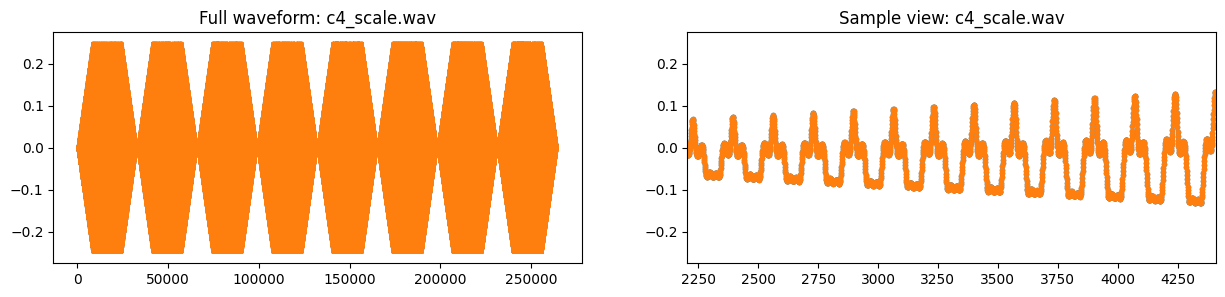

In [30]:
add_wav("c4_scale.wav")

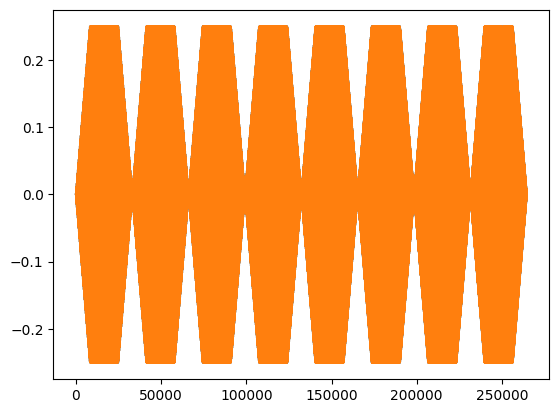

In [12]:
add_wav("c4_scale.wav")

In [32]:
x1 = torch.tensor(wav['c4_scale.wav'], dtype=torch.float32)
x1.size()

torch.Size([264600, 2])

In [42]:
x1 = x1.T
x1.size()

torch.Size([2, 264600])

In [43]:
new_x1 = resample(x1, orig_freq=44500, new_freq=16000) 
new_x1.size()

torch.Size([2, 95138])

new_x1


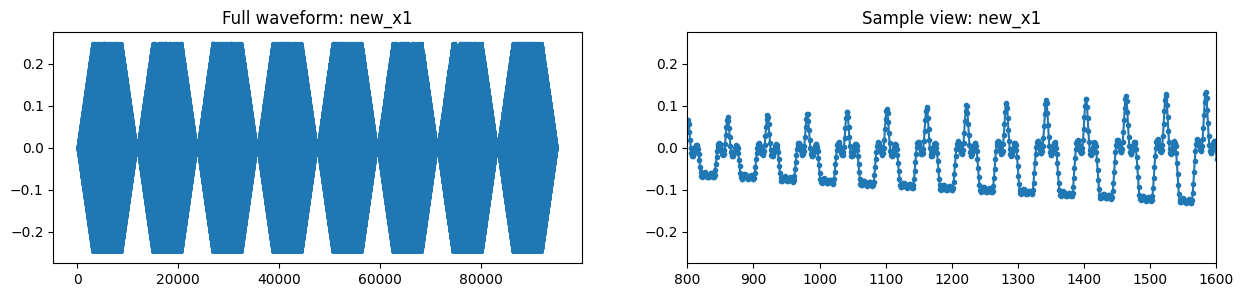

In [47]:
visualize(y=new_x1[0].numpy(), sr=16000, title="new_x1")

torch.Size([2, 47569])
new_x1


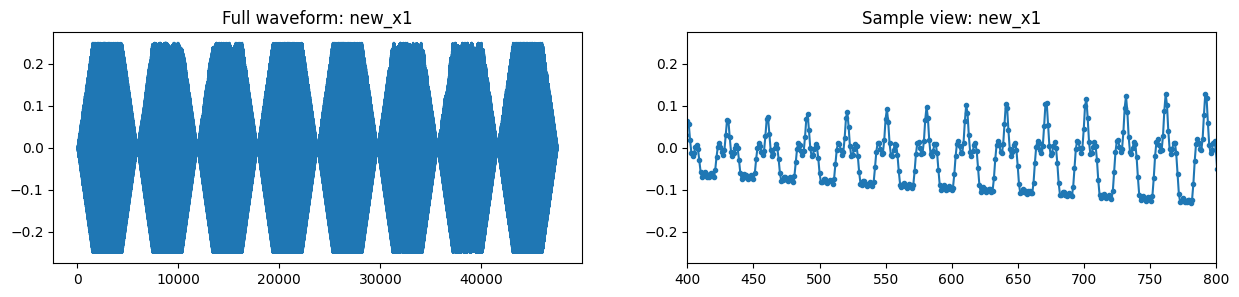

In [48]:
new_x1 = resample(x1, orig_freq=44500, new_freq=8000) 
print(new_x1.size())
visualize(y=new_x1[0].numpy(), sr=8000, title="new_x1")

In [53]:
np.multiply([0.8,0.85],16000)

array([12800., 13600.])

torch.Size([2, 23785])
new_x1


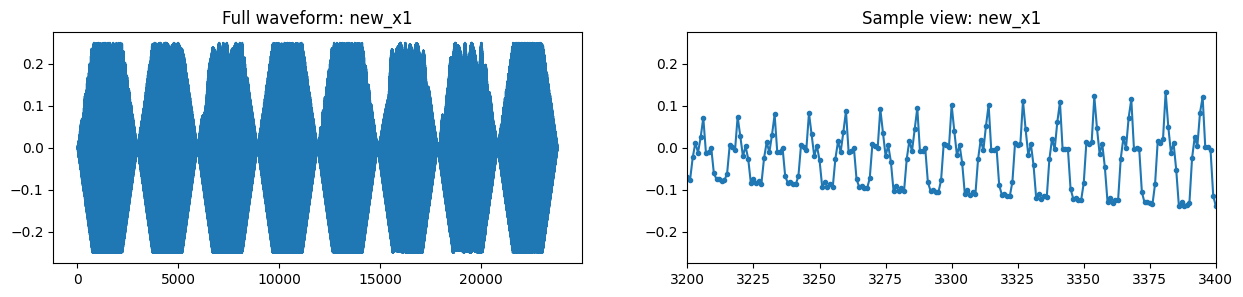

In [55]:
new_x1 = resample(x1, orig_freq=44500, new_freq=4000) 
print(new_x1.size())
visualize(y=new_x1[0].numpy(), sr=4000, title="new_x1", zoom_xlim=[0.8,0.85])

x1


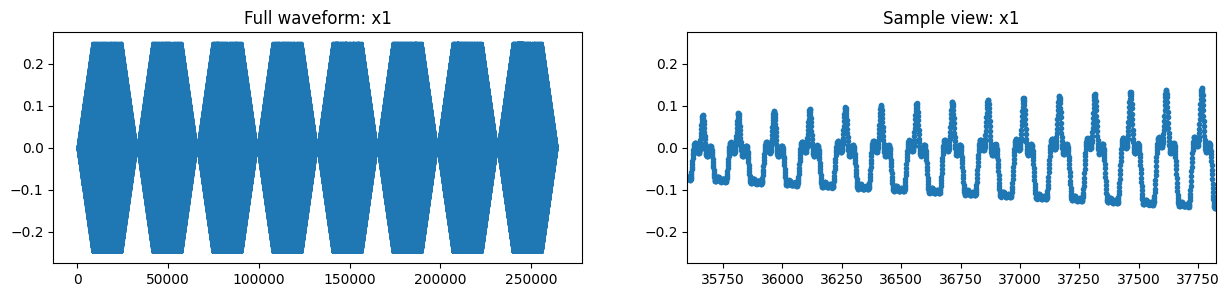

In [56]:
visualize(y=x1[0].numpy(), sr=44500, title="x1", zoom_xlim=[0.8,0.85])

torch.Size([2, 17839])
new_x1


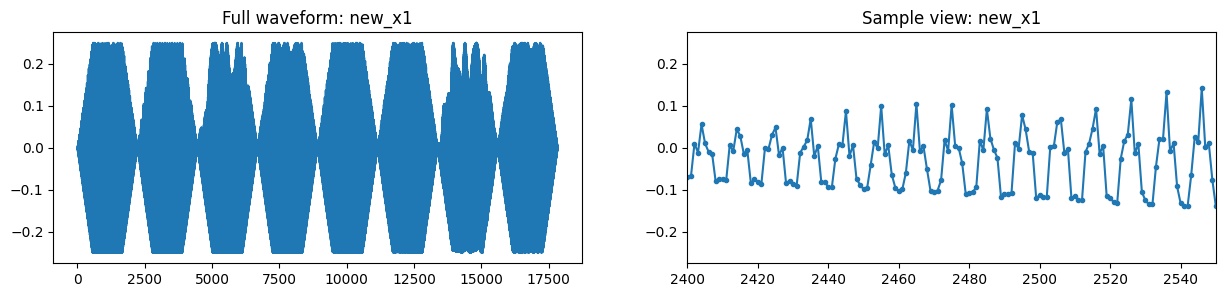

In [58]:
new_x1 = resample(x1, orig_freq=44500, new_freq=3000) 
print(new_x1.size())
visualize(y=new_x1[0].numpy(), sr=3000, title="new_x1", zoom_xlim=[0.8,0.85])

x1


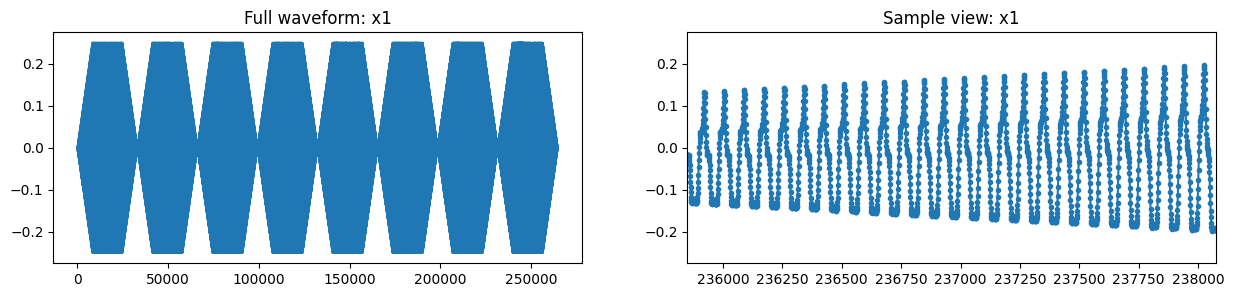

In [60]:
visualize(y=x1[0].numpy(), sr=44500, title="x1", zoom_xlim=[5.3,5.35])

torch.Size([2, 95138])
new_x1


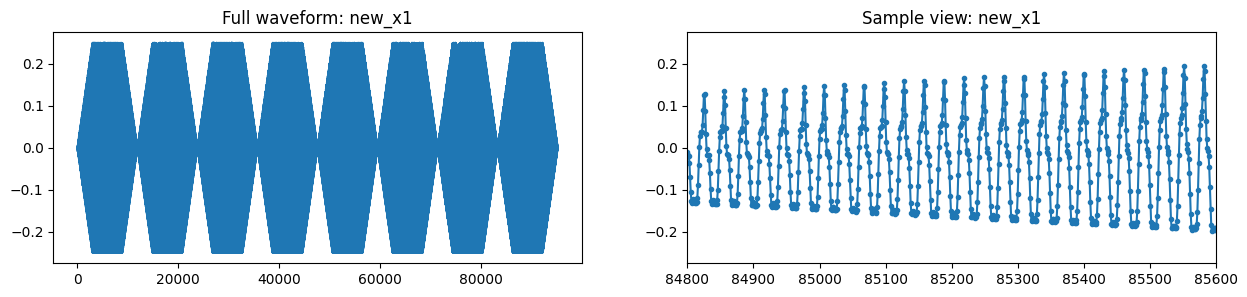

In [61]:
new_x1 = resample(x1, orig_freq=44500, new_freq=16000) 
print(new_x1.size())
visualize(y=new_x1[0].numpy(), sr=16000, title="new_x1", zoom_xlim=[5.3,5.35])

torch.Size([2, 17839])
new_x1


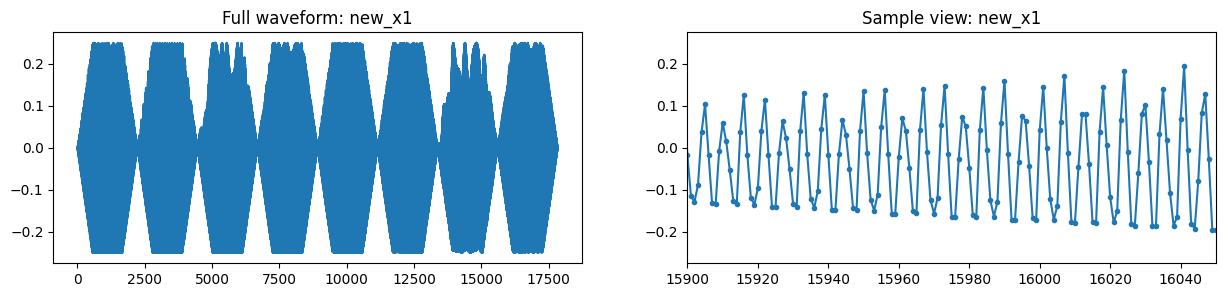

In [62]:
new_x1 = resample(x1, orig_freq=44500, new_freq=3000) 
print(new_x1.size())
visualize(y=new_x1[0].numpy(), sr=3000, title="new_x1", zoom_xlim=[5.3,5.35])

torch.Size([2, 17839])
new_x1


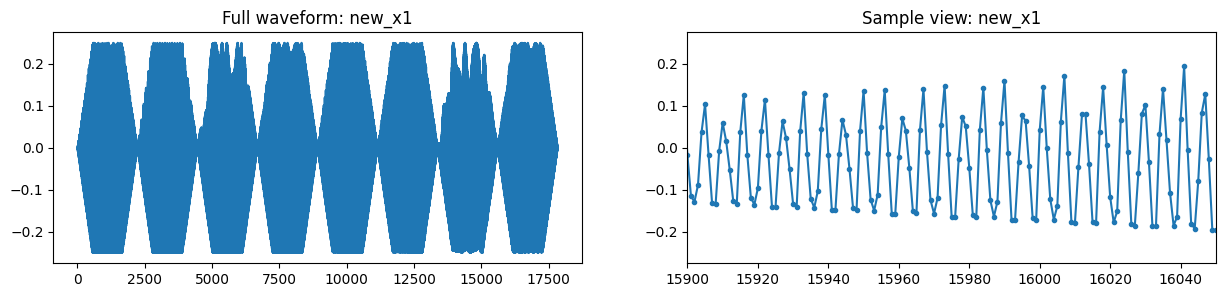

In [66]:
new_x1 = resample(x1, orig_freq=44500, new_freq=3000, lowpass_filter_width=6) 
print(new_x1.size())
visualize(y=new_x1[0].numpy(), sr=3000, title="new_x1", zoom_xlim=[5.3,5.35])

torch.Size([2, 17839])
new_x1


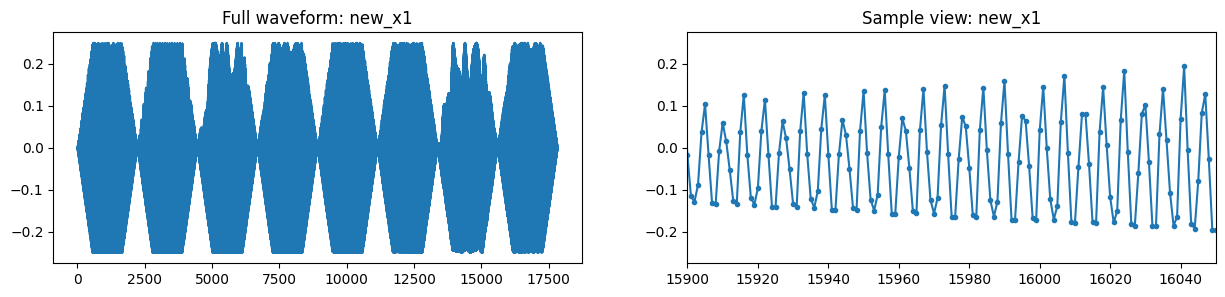

In [67]:
new_x1 = resample(x1, orig_freq=44500, new_freq=3000, lowpass_filter_width=1024) 
print(new_x1.size())
visualize(y=new_x1[0].numpy(), sr=3000, title="new_x1", zoom_xlim=[5.3,5.35])

torch.Size([2, 17839])
new_x1


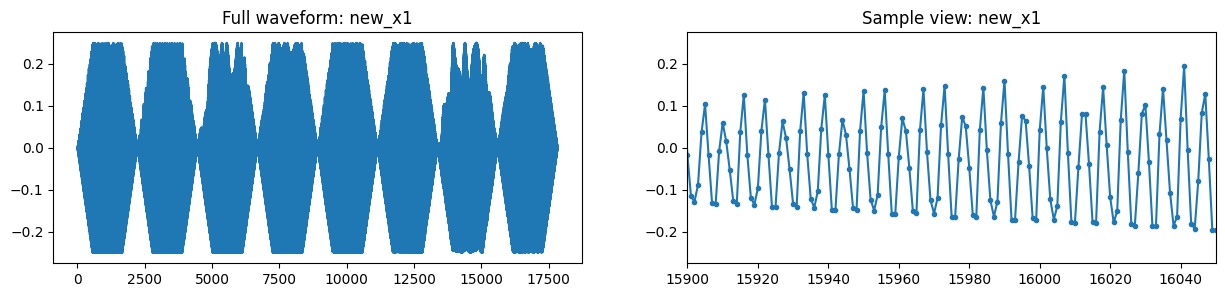

In [68]:
new_x1 = resample(x1, orig_freq=44500, new_freq=3000, lowpass_filter_width=1024, rolloff=0.85) 
print(new_x1.size())
visualize(y=new_x1[0].numpy(), sr=3000, title="new_x1", zoom_xlim=[5.3,5.35])

torch.Size([2, 17839])
new_x1


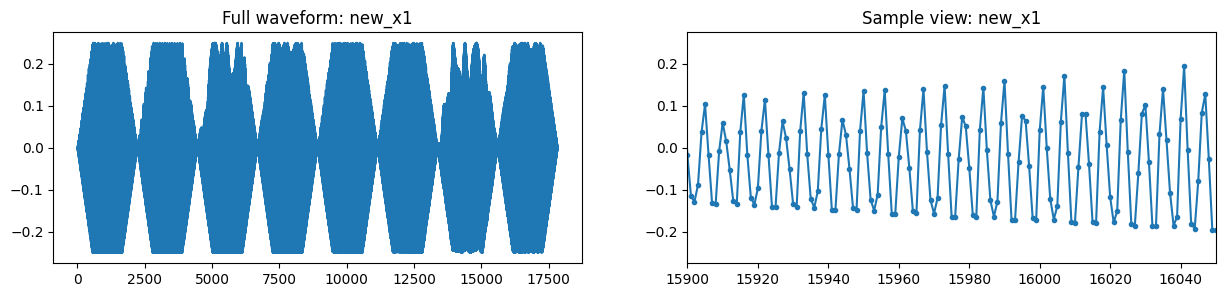

In [69]:
new_x1 = resample(x1, orig_freq=44500, new_freq=3000, lowpass_filter_width=512, rolloff=1) 
print(new_x1.size())
visualize(y=new_x1[0].numpy(), sr=3000, title="new_x1", zoom_xlim=[5.3,5.35])

torch.Size([2, 6089])
new_x1


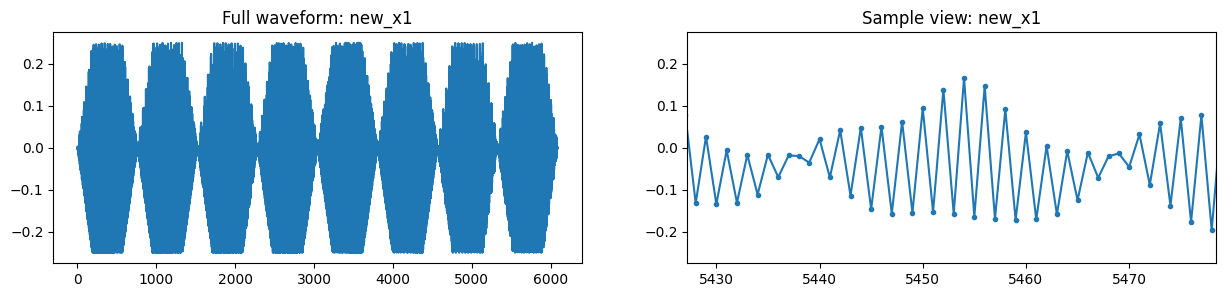

In [71]:
new_x1 = resample(x1, orig_freq=44500, new_freq=1024, lowpass_filter_width=32, rolloff=1) 
print(new_x1.size())
visualize(y=new_x1[0].numpy(), sr=1024, title="new_x1", zoom_xlim=[5.3,5.35])

torch.Size([2, 7136])
new_x1


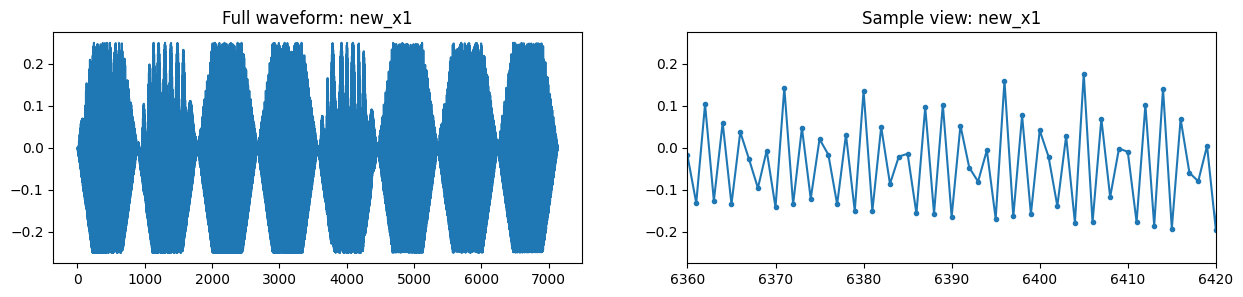

In [74]:
# C5: 523.25 Hz
new_x1 = resample(x1, orig_freq=44500, new_freq=1200, lowpass_filter_width=32, rolloff=1) 
print(new_x1.size())
visualize(y=new_x1[0].numpy(), sr=1200, title="new_x1", zoom_xlim=[5.3,5.35])

In [78]:
kernel, width, orig_freq, new_freq = get_sinc_resample_kernel(
        orig_freq=44500, new_freq=1200, rolloff=1
    )
print(kernel.size(), width, orig_freq, new_freq, sep=', ')

torch.Size([12, 1, 701]), 128, 445, 12


In [75]:
math.gcd(44500,1200)

100

In [ ]:
idx = rearrange(torch.arange(-width, width+orig_freq), 'n -> 1 1 n')
t = rearrange(torch.arange(0, -new_freq, -1), 'n -> n 1 1')

t = (t/new_freq + idx/orig_freq) * orig_freq 
t = t.clamp_(-width, width) 

window = torch.cos(t*math.pi / width / 2) ** 2
kernels = window * torch.where(t == 0, torch.tensor(1.0).to(t), t.sin() / t)

In [86]:
torch.arange(-width, width+orig_freq).view(1,1,-1).size()

torch.Size([1, 1, 701])

In [87]:
torch.arange(0, -new_freq, -1)[:, None, None].size()

torch.Size([12, 1, 1])

In [88]:
from einops import rearrange

In [100]:
test_a = torch.arange(-width, width+orig_freq)
print(rearrange(test_a, 'n -> 1 1 n').size()) # equal to test_a.view(1,1,-1) or test_a[None, None]
print(rearrange(test_a, 'n -> n 1 1').size()) # equal to test_a.view(-1,1,1) or test_a[:,None, None]

torch.Size([1, 1, 701])
torch.Size([701, 1, 1])


In [98]:
torch.arange(0, -32, -1)

tensor([  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12, -13,
        -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27,
        -28, -29, -30, -31])

In [105]:
down_sampling_factor = 4
width = 32
idx = rearrange(torch.arange(-width, width+down_sampling_factor), 'n -> 1 1 n')
t = rearrange(torch.arange(0, -down_sampling_factor, -1), 'n -> n 1 1')
print(idx, t, sep='\n')

tensor([[[-32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19,
          -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,
           -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
           10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
           24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35]]])
tensor([[[ 0]],

        [[-1]],

        [[-2]],

        [[-3]]])


In [110]:
(t + idx/down_sampling_factor)*down_sampling_factor

tensor([[[-32., -31., -30., -29., -28., -27., -26., -25., -24., -23., -22.,
          -21., -20., -19., -18., -17., -16., -15., -14., -13., -12., -11.,
          -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
            1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
           12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
           23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
           34.,  35.]],

        [[-36., -35., -34., -33., -32., -31., -30., -29., -28., -27., -26.,
          -25., -24., -23., -22., -21., -20., -19., -18., -17., -16., -15.,
          -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
           -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
            8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
           19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,
           30.,  31.]],

        [[-40., -39., -38., -37., -36.

In [150]:
(t + idx/down_sampling_factor)*down_sampling_factor/width/2

tensor([[[-0.5000, -0.4844, -0.4688, -0.4531, -0.4375, -0.4219, -0.4062,
          -0.3906, -0.3750, -0.3594, -0.3438, -0.3281, -0.3125, -0.2969,
          -0.2812, -0.2656, -0.2500, -0.2344, -0.2188, -0.2031, -0.1875,
          -0.1719, -0.1562, -0.1406, -0.1250, -0.1094, -0.0938, -0.0781,
          -0.0625, -0.0469, -0.0312, -0.0156,  0.0000,  0.0156,  0.0312,
           0.0469,  0.0625,  0.0781,  0.0938,  0.1094,  0.1250,  0.1406,
           0.1562,  0.1719,  0.1875,  0.2031,  0.2188,  0.2344,  0.2500,
           0.2656,  0.2812,  0.2969,  0.3125,  0.3281,  0.3438,  0.3594,
           0.3750,  0.3906,  0.4062,  0.4219,  0.4375,  0.4531,  0.4688,
           0.4844,  0.5000,  0.5156,  0.5312,  0.5469]],

        [[-0.5625, -0.5469, -0.5312, -0.5156, -0.5000, -0.4844, -0.4688,
          -0.4531, -0.4375, -0.4219, -0.4062, -0.3906, -0.3750, -0.3594,
          -0.3438, -0.3281, -0.3125, -0.2969, -0.2812, -0.2656, -0.2500,
          -0.2344, -0.2188, -0.2031, -0.1875, -0.1719, -0.1562, -0

In [131]:
tt = torch.arange(-5,5,1)
tt1 = torch.cos(tt*math.pi) ** 2
tt2 = 0.5 + 0.5*torch.cos(tt*math.pi*2)
torch.allclose(tt1, tt2)

True

In [135]:
tt

tensor([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4])

In [137]:
torch.where(tt == 0, torch.tensor(1.0).to(tt), tt)

tensor([-5, -4, -3, -2, -1,  1,  1,  2,  3,  4])

In [126]:
tt.sin()

tensor([ 0.9589,  0.7568, -0.1411, -0.9093, -0.8415,  0.0000,  0.8415,  0.9093,
         0.1411, -0.7568])

In [134]:
torch.arange(-0.5,0.5,1/10)

tensor([-0.5000, -0.4000, -0.3000, -0.2000, -0.1000,  0.0000,  0.1000,  0.2000,
         0.3000,  0.4000])

In [133]:
torch.arange(-5,5,1)/10

tensor([-0.5000, -0.4000, -0.3000, -0.2000, -0.1000,  0.0000,  0.1000,  0.2000,
         0.3000,  0.4000])

torch.Size([2, 23785])
new_x1


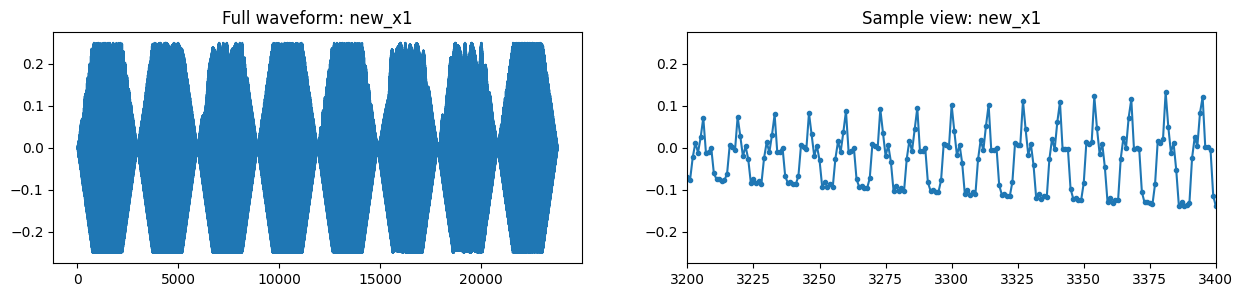

In [164]:
new_x1 = resample(x1, orig_freq=44500, new_freq=4000, rolloff=0.99) 
print(new_x1.size())
visualize(y=new_x1[0].numpy(), sr=4000, title="new_x1", zoom_xlim=[0.8,0.85])

In [239]:
rearrange(x1, 'c n -> c 1 n').size()

torch.Size([2, 1, 264600])

In [304]:
import time

torch.Size([8, 1, 349])
0.0124 seconds
torch.Size([2, 1, 23785])
new2_x1


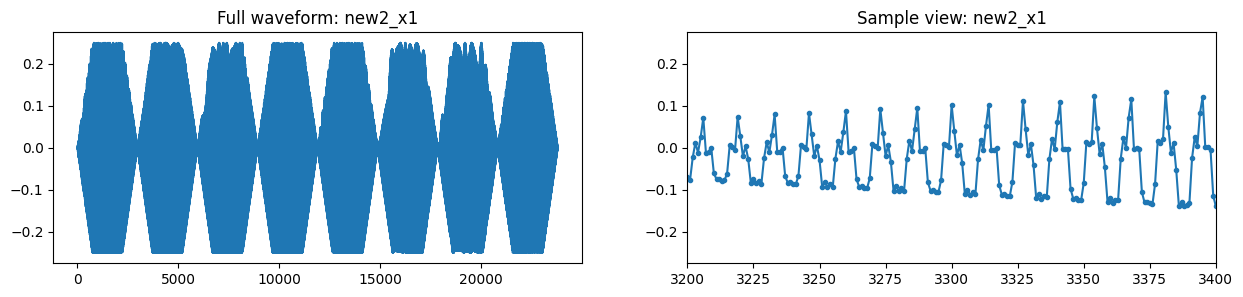

In [309]:
tik = time.perf_counter()
new2_x1 = resample2(rearrange(x1, 'c n -> c 1 n'), orig_freq=44500, new_freq=4000, rolloff=0.99) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new2_x1.size())
visualize(y=new2_x1[0][0].numpy(), sr=4000, title="new2_x1", zoom_xlim=[0.8,0.85])

torch.Size([8, 1, 349])
0.7898 seconds
torch.Size([2, 1, 23785])
new2_x1


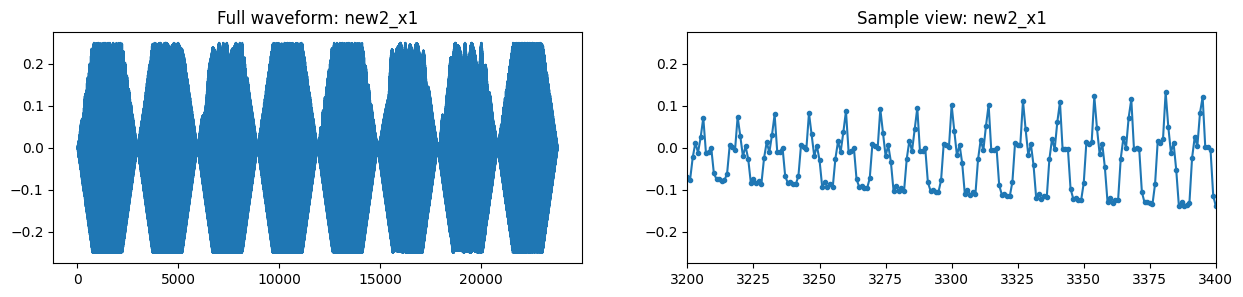

In [344]:
tik = time.perf_counter()
new3_x1 = resample3(rearrange(x1, 'c n -> c 1 n'), orig_freq=44500, new_freq=4000, rolloff=0.99) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new3_x1.size())
visualize(y=new3_x1[0][0].numpy(), sr=4000, title="new2_x1", zoom_xlim=[0.8,0.85])

In [345]:
torch.allclose(new2_x1[0][0], new3_x1[0][0])

False

torch.Size([8, 1, 8171])
0.1205 seconds
torch.Size([2, 1, 23785])
new2_x1


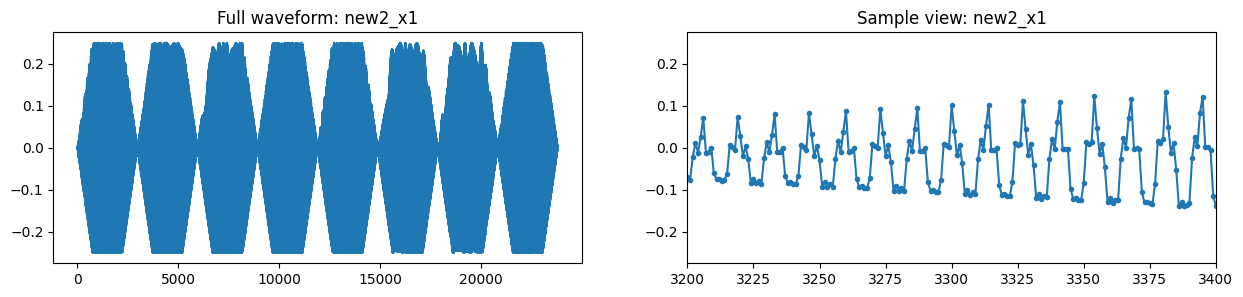

In [313]:
tik = time.perf_counter()
new2_x1 = resample2(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4000, rolloff=0.99,
                   lowpass_filter_width=4000) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new2_x1.size())
visualize(y=new2_x1[0][0].numpy(), sr=4000, title="new2_x1", zoom_xlim=[0.8,0.85])

torch.Size([8, 1, 8171])
1.2819 seconds
torch.Size([2, 1, 23785])
new2_x1


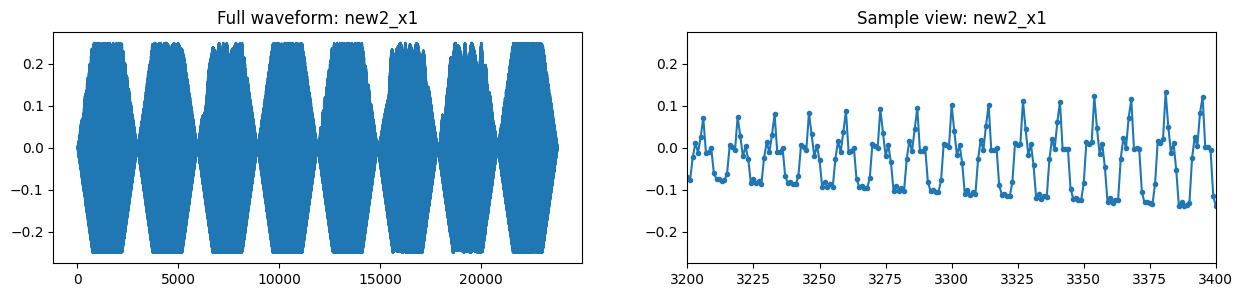

In [317]:
tik = time.perf_counter()
new3_x1 = resample3(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4000, rolloff=0.99,
                   lowpass_filter_width=4000) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new3_x1.size())
visualize(y=new3_x1[0][0].numpy(), sr=4000, title="new2_x1", zoom_xlim=[0.8,0.85])

0.0969 seconds
torch.Size([2, 1, 23785])
new4_x1


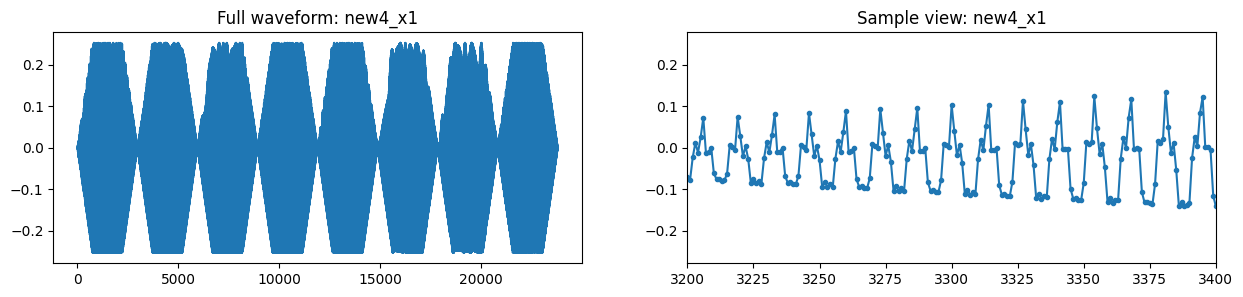

In [352]:
tik = time.perf_counter()
new4_x1 = resample3(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4000, rolloff=0.99,
                   lowpass_filter_width=4000) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new4_x1.size())
visualize(y=new4_x1[0][0].numpy(), sr=4000, title="new4_x1", zoom_xlim=[0.8,0.85])

0.1111 seconds
torch.Size([2, 1, 23785])
new5_x1


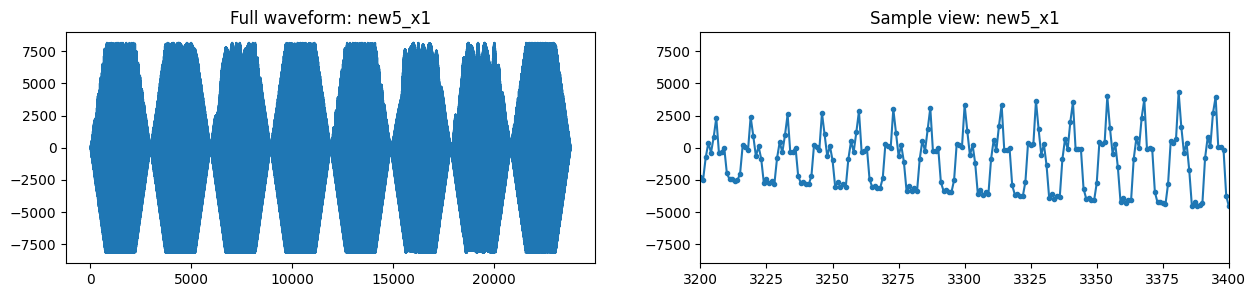

In [350]:
tik = time.perf_counter()
new5_x1 = resample3(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4000, rolloff=0.99,
                   lowpass_filter_width=4000) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new5_x1.size())
visualize(y=new5_x1[0][0].numpy(), sr=4000, title="new5_x1", zoom_xlim=[0.8,0.85])

7.0999 seconds
torch.Size([23785])
new6_x1


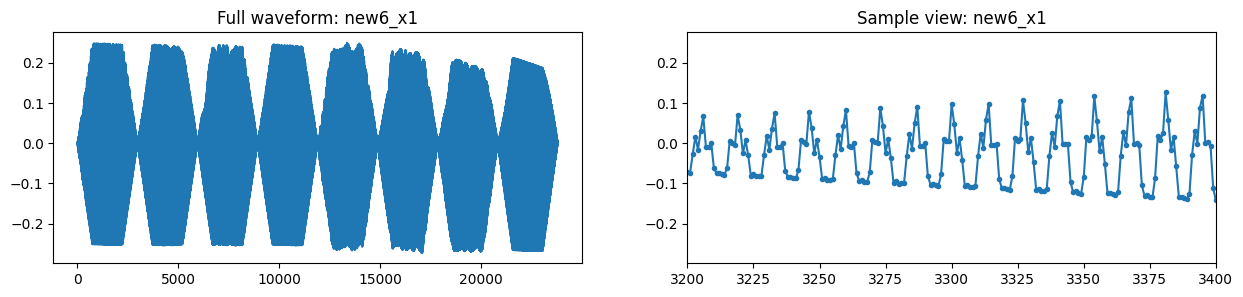

In [371]:
tik = time.perf_counter()
new6_x1 = aF.resample(x1[0], 
                    orig_freq=44500, new_freq=4000, rolloff=0.99,
                   lowpass_filter_width=4000) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new6_x1.size())
visualize(y=new6_x1.numpy(), sr=4000, title="new6_x1", zoom_xlim=[0.8,0.85])

In [340]:
torch.allclose(new2_x1[0][0], new4_x1[0][0])

True

In [171]:
math.ceil(2/0.5)

4

In [162]:
1/0.99

1.0101010101010102

In [184]:
inputs = torch.randn(33, 16, 30) # batch, in_channel, in_seq_length
test_filters = torch.randn(20, 16, 5) # out_channel, in_channel, kernel_length
F.conv1d(inputs, test_filters).size() # batch, out_channel, out_seq_length

torch.Size([33, 20, 26])

In [280]:
from torchaudio import functional as aF

In [351]:
def get_sinc_resample_kernel3(
    orig_freq: int, new_freq: int,
    lowpass_filter_width: int = 128, rolloff: float = 0.97, 
    device: torch.device = _CPU, dtype: Optional[torch.dtype] = torch.float32,
):
    gcd = math.gcd(orig_freq, new_freq) # Greatest common devider
    orig_freq, new_freq = orig_freq//gcd, new_freq//gcd
    width = math.ceil(lowpass_filter_width * orig_freq / rolloff) # rolloff will always < 1 => width = lpf_width+1
    idx = torch.arange(-width, width+orig_freq, dtype=dtype, device=device)
    idx = rearrange(idx, 'n -> 1 1 n')

    t = torch.arange(0, -new_freq, -1, dtype=dtype, device=device)
    t = rearrange(t, 'n -> n 1 1')
    t = (t/new_freq + idx/orig_freq) * orig_freq * rolloff

    window = 0.5 + 0.5*torch.cos(t* math.pi/lowpass_filter_width) # hann
    kernels = torch.sinc(t) * window 
    kernels = kernels.to(dtype=dtype)
    return kernels, width, orig_freq, new_freq

def apply_sinc_resample_kernel3(
    waveform: torch.Tensor, orig_freq: int, new_freq: int, kernel: torch.Tensor, width: int,
) -> torch.Tensor:
    if len(waveform.size()) == 1: # seq_length
        waveform = rearrange(waveform, 'n -> 1 1 n')
    batch, in_channel, length = waveform.size() # (batch, channel, seq_length)
    waveform = F.pad(waveform, (width, width + orig_freq)) # pad the last dimension (pad_left, pad_right)
    # kernel = kernel.flip(1) # CHANGED: out_channel, kernel_length => same result...
    kernel = kernel.repeat(1, in_channel, 1) # (out_channel, in_channel, kernel_length) -> repeat along in_channel 
    resampled = F.conv1d(waveform, kernel, stride=orig_freq)  # batch, out_channel, out_seq_length
    # resampled = fft_conv(waveform, kernel, stride=orig_freq)  # CHANGED: batch, out_channel, out_seq_length
    resampled = rearrange(resampled, 'b c n -> b 1 (n c)')
    target_length = math.ceil(new_freq * length / orig_freq)
    resampled = resampled[..., :target_length]
    return resampled

def resample3(
    waveform: torch.Tensor, orig_freq: int, new_freq: int,
    lowpass_filter_width: int = 128, rolloff: float = 0.97,
) -> torch.Tensor:
    if orig_freq == new_freq:
        return waveform
    
    if orig_freq <= 0.0 or new_freq <= 0.0 or lowpass_filter_width <= 0:
        raise ValueError("Original frequency, desired frequecy and filter width must be positive")
    
    waveform = waveform.to(dtype=torch.float32)
    kernel, width, orig_freq, new_freq = get_sinc_resample_kernel3(
        orig_freq, new_freq,
        lowpass_filter_width, rolloff,
        waveform.device, waveform.dtype,
    )
    resampled = apply_sinc_resample_kernel3(waveform, orig_freq, new_freq, kernel, width)
    return resampled

In [368]:
base_freq = min(orig_freq, new_freq)
base_freq *= rolloff
width = math.ceil(lowpass_filter_width * orig_freq / base_freq)
print(base_freq, width, sep=' ')

0.97 1056


torch.Size([1, 1, 2240])
tensor([[[-8.0000, -7.9949, -7.9873,  ...,  8.0000,  8.0000,  8.0000]]])
torch.Size([1, 1, 2240])
tensor([[[1.9107e-15, 9.9405e-07, 6.1752e-06,  ..., 1.9107e-15,
          1.9107e-15, 1.9107e-15]]])
torch.Size([1, 1, 2240])
tensor([[[ 4.0293e-25, -4.7843e-12, -7.4129e-11,  ...,  4.0293e-25,
           4.0293e-25,  4.0293e-25]]])


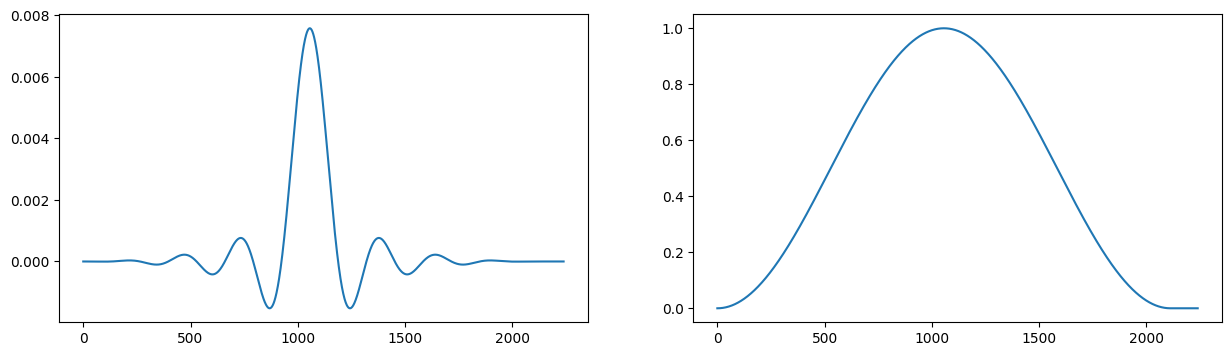

In [373]:
idx = torch.arange(-width, width + orig_freq)[None, None] / orig_freq
t = torch.arange(0, -new_freq, -1)[:, None, None] / new_freq + idx
t *= base_freq
t = t.clamp_(-lowpass_filter_width, lowpass_filter_width)
print(t.size())
print(t)
window = torch.cos(t * math.pi / lowpass_filter_width / 2) ** 2
print(window.size())
print(window)
t *= math.pi

scale = base_freq / orig_freq
kernels = torch.where(t == 0, torch.tensor(1.0).to(t), t.sin() / t)
kernels *= window * scale
print(kernels.size())
print(kernels)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,4))
axes[0].plot(kernels[0][0])
axes[1].plot(window[0][0])

In [360]:
orig_freq, new_freq, lowpass_filter_width, rolloff = 128, 1, 8, 0.97
width = math.ceil(lowpass_filter_width / rolloff) # rolloff will always < 1 => width = lpf_width+1
idx = torch.arange(-width, width+orig_freq)
print(idx)
idx = rearrange(idx, 'n -> 1 1 n')

t = torch.arange(0, -new_freq, -1)
print(t)
t = rearrange(t, 'n -> n 1 1')

t = (t/new_freq + idx/orig_freq) * orig_freq * rolloff
print(t)

window = 0.5 + 0.5*torch.cos(t* math.pi/lowpass_filter_width) # hann
print(window)
kernels = torch.sinc(t) * window 

tensor([ -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
          5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
         33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
         47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136])
tensor([0])
tensor([[[ -8.7300,  -7.7600,  -6.7900,  -5.8200,  -4.8500,  -3.8800,  -2.9100,
           -1.9400,  -0.9700,   0.0000,   0.9700,   1.9400,   2.9100,   3.8800,
         

In [367]:
taps.shape

(150,)

torch.Size([1, 1, 146]) torch.Size([1, 1, 146])


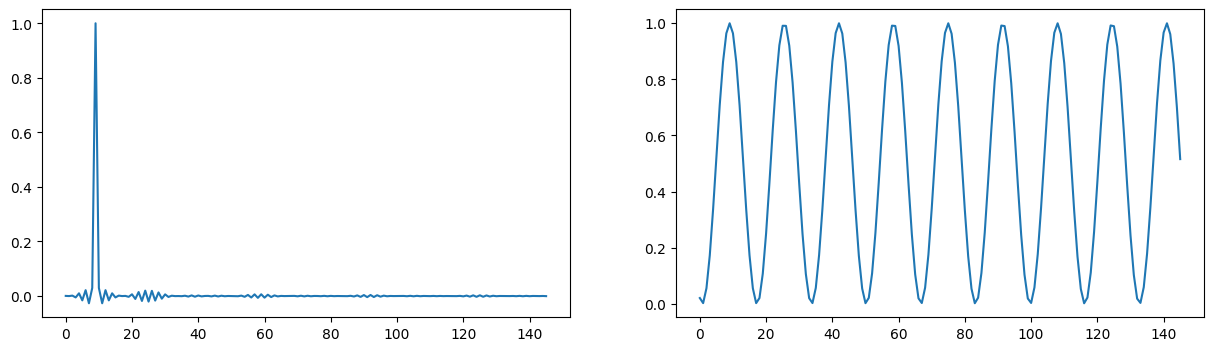

In [356]:
wd11, k11, w11, of11, nf11 = get_sinc_resample_kernel4(128,1, lowpass_filter_width=8)
print(k11.size(), wd11.size(), sep=' ')
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,4))
axes[0].plot(k11[0][0])
axes[1].plot(wd11[0][0])

In [375]:
from scipy import signal
taps = signal.firwin2(numtaps=150, 
                      freq=[0.0, 128*0.097-8/2, 128*0.097+8/2, 128], 
                      gain=[1.0, 1.0, 0.0,0.0],
                      window='hamming', fs=128*2)
print(taps)

[-2.68766633e-05 -1.59444769e-05 -4.26762793e-06  6.87564480e-06
  1.62131071e-05  2.26161419e-05  2.52740599e-05  2.38882402e-05
  1.88500475e-05  1.13516205e-05  3.37404719e-06 -2.49252983e-06
 -3.41642944e-06  3.14005419e-06  1.87826326e-05  4.35529214e-05
  7.54397161e-05  1.10176299e-04  1.41441268e-04  1.61523891e-04
  1.62432861e-04  1.37331915e-04  8.20944375e-05 -3.29832351e-06
 -1.13816319e-04 -2.39168430e-04 -3.64501929e-04 -4.72056531e-04
 -5.43642278e-04 -5.63631486e-04 -5.22003931e-04 -4.16894909e-04
 -2.56094569e-04 -5.70485694e-05  1.54887805e-04  3.49908973e-04
  4.98577817e-04  5.77341255e-04  5.73841289e-04  4.91004810e-04
  3.48942948e-04  1.83917601e-04  4.40267804e-05 -1.82210715e-05
  4.42997366e-05  2.62454755e-04  6.40582571e-04  1.14873038e-03
  1.71920391e-03  2.24886104e-03  2.60791188e-03  2.65510401e-03
  2.25817641e-03  1.31749809e-03 -2.09986147e-04 -2.28986013e-03
 -4.79580888e-03 -7.50466290e-03 -1.01030360e-02 -1.22064061e-02
 -1.33899621e-02 -1.32289

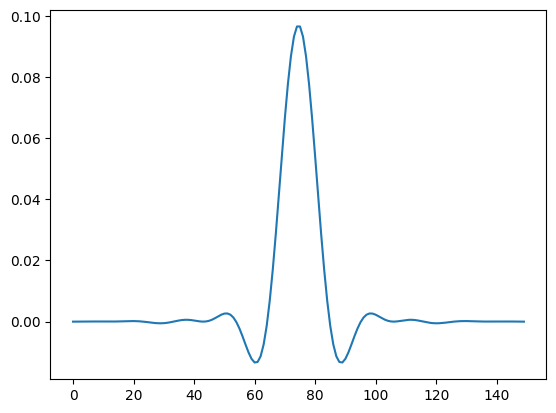

In [376]:
plt.plot(taps)

In [374]:
taps.shape

(150,)

torch.Size([1, 1, 146])
torch.Size([1, 1, 146])
torch.Size([1, 1, 146]) 9 128 1
torch.Size([1, 1, 146]) 9 128 1


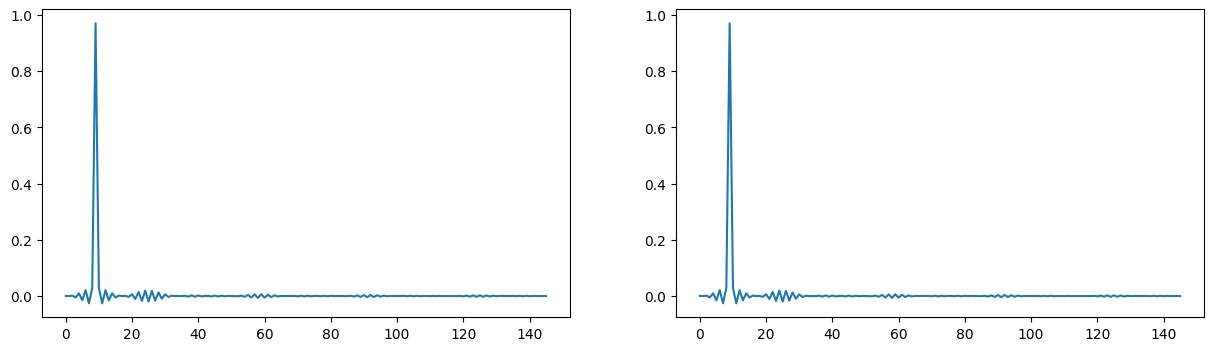

In [281]:
k1, w1, of1, nf1 = get_sinc_resample_kernel3(128,1, lowpass_filter_width=8)
k2, w2, of2, nf2 = get_sinc_resample_kernel2(128,1, lowpass_filter_width=8)
print(k1.size(), w1, of1, nf1, sep=' ')
print(k2.size(), w2, of2, nf2, sep=' ')
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,4))
axes[0].plot(k1[0][0])
axes[1].plot(k2[0][0])

In [291]:
k_test = torch.arange(1,10,1).repeat(2,1) # k1[0][0]
k_test.flip(1)

tensor([[9, 8, 7, 6, 5, 4, 3, 2, 1],
        [9, 8, 7, 6, 5, 4, 3, 2, 1]])

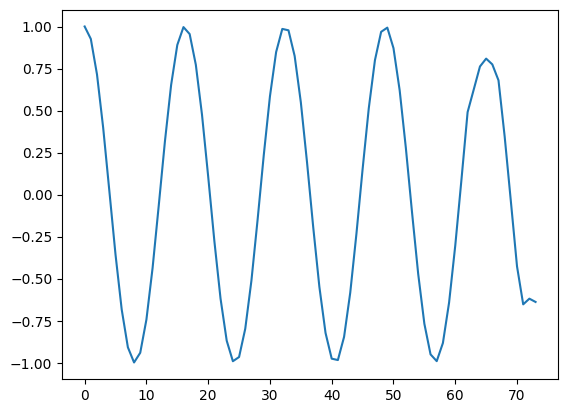

In [320]:
plt.plot(torch.fft.rfft(k1[0][0]))

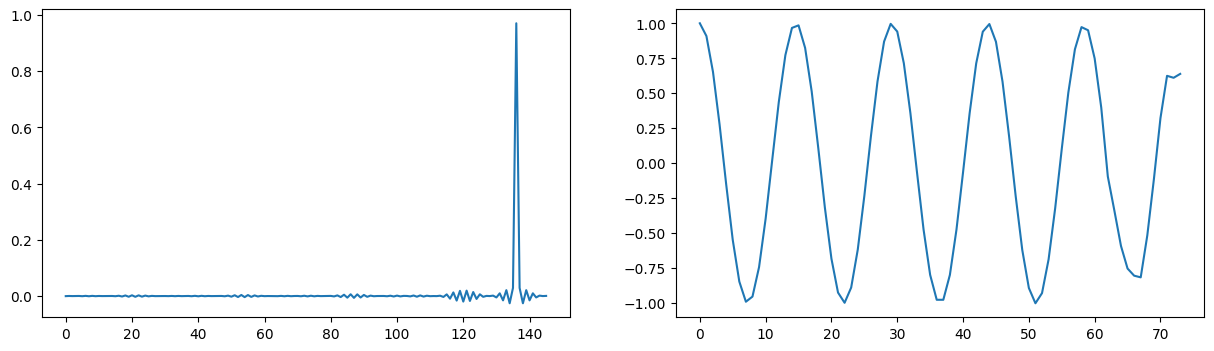

In [327]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,4))

axes[0].plot(k1[0][0].flip(0))
axes[1].plot(torch.fft.rfft(k1[0][0].flip(0)))

torch.Size([1, 1, 194])
torch.Size([1, 1, 194])
torch.Size([1, 1, 194]) 33 128 1
torch.Size([1, 1, 194]) 33 128 1


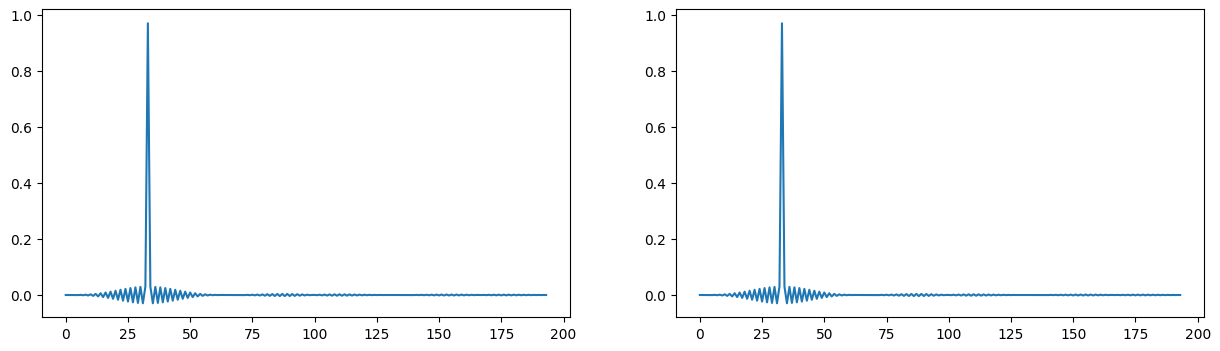

In [276]:
k1, w1, of1, nf1 = get_sinc_resample_kernel3(128,1, lowpass_filter_width=32)
k2, w2, of2, nf2 = get_sinc_resample_kernel2(128,1, lowpass_filter_width=32)
print(k1.size(), w1, of1, nf1, sep=' ')
print(k2.size(), w2, of2, nf2, sep=' ')
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,4))
axes[0].plot(k1[0][0])
axes[1].plot(k2[0][0])

torch.Size([1, 1, 392])
torch.Size([1, 1, 392])
torch.Size([1, 1, 392]) 132 128 1
torch.Size([1, 1, 392]) 132 128 1


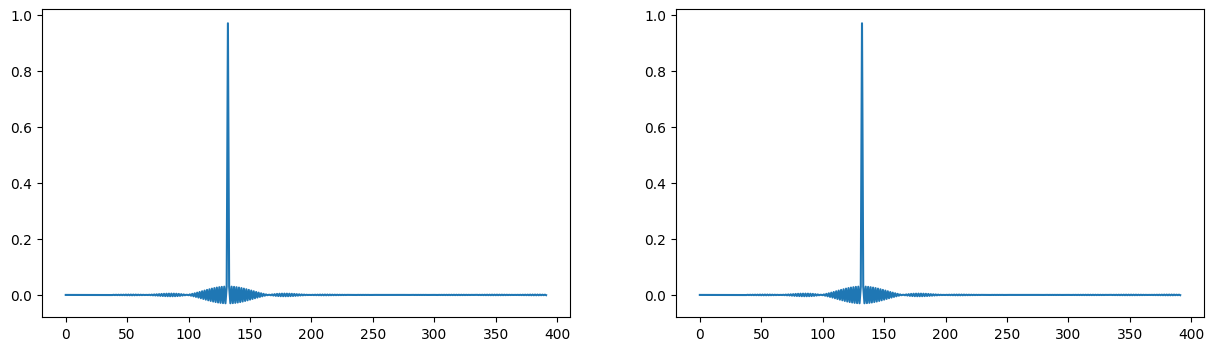

In [277]:
k1, w1, of1, nf1 = get_sinc_resample_kernel3(128,1, lowpass_filter_width=128)
k2, w2, of2, nf2 = get_sinc_resample_kernel2(128,1, lowpass_filter_width=128)
print(k1.size(), w1, of1, nf1, sep=' ')
print(k2.size(), w2, of2, nf2, sep=' ')
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,4))
axes[0].plot(k1[0][0])
axes[1].plot(k2[0][0])

torch.Size([27, 1, 194])
torch.Size([27, 1, 194])
torch.Size([27, 1, 194]) 33 128 27
torch.Size([27, 1, 194]) 33 128 27


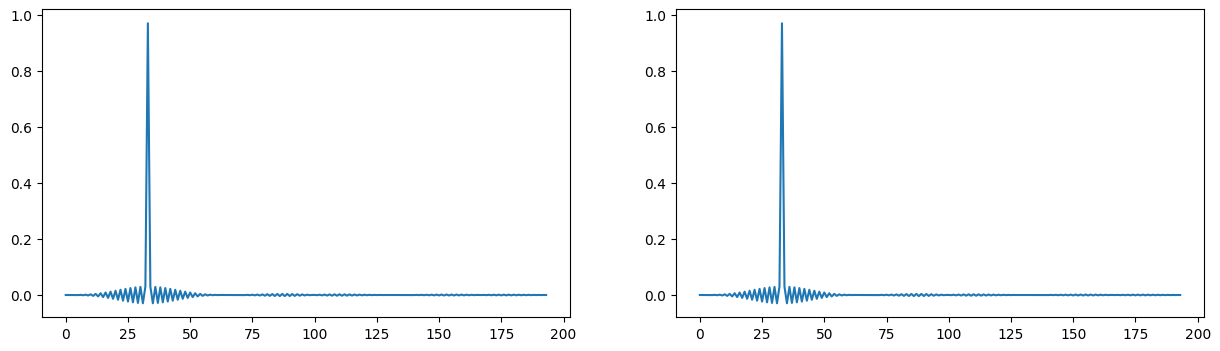

In [279]:
k1, w1, of1, nf1 = get_sinc_resample_kernel3(128,27, lowpass_filter_width=32)
k2, w2, of2, nf2 = get_sinc_resample_kernel2(128,27, lowpass_filter_width=32)
print(k1.size(), w1, of1, nf1, sep=' ')
print(k2.size(), w2, of2, nf2, sep=' ')
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,4))
axes[0].plot(k1[0][0])
axes[1].plot(k2[0][0])

In [260]:
def get_sinc_resample_kernel2(
    orig_freq: int, new_freq: int,
    lowpass_filter_width: int = 128, rolloff: float = 0.97, 
    device: torch.device = _CPU, dtype: Optional[torch.dtype] = torch.float32,
):
    gcd = math.gcd(orig_freq, new_freq) # Greatest common devider
    orig_freq, new_freq = orig_freq//gcd, new_freq//gcd
    width = math.ceil(lowpass_filter_width / rolloff) # rolloff will always < 1 => width = lpf_width+1
    idx = torch.arange(-width, width+orig_freq, dtype=dtype, device=device)
    idx = rearrange(idx, 'n -> 1 1 n')

    t = torch.arange(0, -new_freq, -1, dtype=dtype, device=device)
    t = rearrange(t, 'n -> n 1 1')
    t = (t/new_freq + idx/orig_freq) * orig_freq * rolloff

    window = 0.5 + 0.5*torch.cos(t* math.pi/lowpass_filter_width) # hann
    kernels = torch.sinc(t) * window * rolloff
    kernels = kernels.to(dtype=dtype)
    print(kernels.size())
    return kernels, width, orig_freq, new_freq

In [257]:
def apply_sinc_resample_kernel2(
    waveform: torch.Tensor, orig_freq: int, new_freq: int, kernel: torch.Tensor, width: int,
) -> torch.Tensor:
    if len(waveform.size()) == 1: # seq_length
        waveform = rearrange(waveform, 'n -> 1 1 n')
    batch, in_channel, length = waveform.size() # (batch, channel, seq_length)
    waveform = F.pad(waveform, (width, width + orig_freq)) # pad the last dimension (pad_left, pad_right)
    kernel = kernel.repeat(1, in_channel, 1) # (out_channel, in_channel, kernel_length) -> repeat along in_channel 
    resampled = F.conv1d(waveform, kernel, stride=orig_freq)  # batch, out_channel, out_seq_length
    resampled = rearrange(resampled, 'b c n -> b 1 (n c)')
    target_length = math.ceil(new_freq * length / orig_freq)
    resampled = resampled[..., :target_length]
    return resampled


def resample2(
    waveform: torch.Tensor, orig_freq: int, new_freq: int,
    lowpass_filter_width: int = 128, rolloff: float = 0.97,
) -> torch.Tensor:
    if orig_freq == new_freq:
        return waveform
    
    if orig_freq <= 0.0 or new_freq <= 0.0 or lowpass_filter_width <= 0:
        raise ValueError("Original frequency, desired frequecy and filter width must be positive")
    
    waveform = waveform.to(dtype=torch.float32)
    kernel, width, orig_freq, new_freq = get_sinc_resample_kernel2(
        orig_freq, new_freq,
        lowpass_filter_width, rolloff,
        waveform.device, waveform.dtype,
    )
    resampled = apply_sinc_resample_kernel2(waveform, orig_freq, new_freq, kernel, width)
    return resampled

In [255]:
rearrange(test_pad, 'a b -> a 1 b').repeat(1, 4, 1)

tensor([[[0.0716, 0.5718, 0.6487],
         [0.0716, 0.5718, 0.6487],
         [0.0716, 0.5718, 0.6487],
         [0.0716, 0.5718, 0.6487]],

        [[0.1483, 0.9911, 0.7686],
         [0.1483, 0.9911, 0.7686],
         [0.1483, 0.9911, 0.7686],
         [0.1483, 0.9911, 0.7686]]])

In [217]:
test_pad = torch.rand(2,3)
print(test_pad)
test_pad_padded = F.pad(test_pad, (11,7))
print(test_pad_padded.size())
test_pad_padded

tensor([[0.0716, 0.5718, 0.6487],
        [0.1483, 0.9911, 0.7686]])
torch.Size([2, 21])


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0716, 0.5718, 0.6487, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1483, 0.9911, 0.7686, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]])

In [509]:
from functools import partial
from typing import Iterable, Tuple, Union

import torch
import torch.nn.functional as f
from torch import Tensor, nn
from torch.fft import irfftn, rfftn
from math import ceil, floor


def complex_matmul(a: Tensor, b: Tensor, groups: int = 1) -> Tensor:
    """Multiplies two complex-valued tensors."""
    # Scalar matrix multiplication of two tensors, over only the first channel
    # dimensions. Dimensions 3 and higher will have the same shape after multiplication.
    # We also allow for "grouped" multiplications, where multiple sections of channels
    # are multiplied independently of one another (required for group convolutions).
    a = a.view(a.size(0), groups, -1, *a.shape[2:])
    b = b.view(groups, -1, *b.shape[1:])

    a = torch.movedim(a, 2, a.dim() - 1).unsqueeze(-2)
    b = torch.movedim(b, (1, 2), (b.dim() - 1, b.dim() - 2))

    # complex value matrix multiplication
    real = a.real @ b.real - a.imag @ b.imag
    imag = a.imag @ b.real + a.real @ b.imag
    real = torch.movedim(real, real.dim() - 1, 2).squeeze(-1)
    imag = torch.movedim(imag, imag.dim() - 1, 2).squeeze(-1)
    c = torch.zeros(real.shape, dtype=torch.complex64, device=a.device)
    c.real, c.imag = real, imag

    return c.view(c.size(0), -1, *c.shape[3:])


def to_ntuple(val: Union[int, Iterable[int]], n: int) -> Tuple[int, ...]:
    """Casts to a tuple with length 'n'.  Useful for automatically computing the
    padding and stride for convolutions, where users may only provide an integer.

    Args:
        val: (Union[int, Iterable[int]]) Value to cast into a tuple.
        n: (int) Desired length of the tuple

    Returns:
        (Tuple[int, ...]) Tuple of length 'n'
    """
    if isinstance(val, Iterable):
        out = tuple(val)
        if len(out) == n:
            return out
        else:
            raise ValueError(f"Cannot cast tuple of length {len(out)} to length {n}.")
    else:
        return n * (val,)


def fft_conv(
    signal: Tensor,
    kernel: Tensor,
    bias: Tensor = None,
    padding: Union[int, Iterable[int], str] = 0,
    padding_mode: str = "constant",
    stride: Union[int, Iterable[int]] = 1,
    dilation: Union[int, Iterable[int]] = 1,
    groups: int = 1,
) -> Tensor:
    """Performs N-d convolution of Tensors using a fast fourier transform, which
    is very fast for large kernel sizes. Also, optionally adds a bias Tensor after
    the convolution (in order ot mimic the PyTorch direct convolution).

    Args:
        signal: (Tensor) Input tensor to be convolved with the kernel.
        kernel: (Tensor) Convolution kernel.
        bias: (Tensor) Bias tensor to add to the output.
        padding: (Union[int, Iterable[int], str) If int, Number of zero samples to pad then
            input on the last dimension. If str, "same" supported to pad input for size preservation.
        padding_mode: (str) Padding mode to use from {constant, reflection, replication}.
                      reflection not available for 3d.
        stride: (Union[int, Iterable[int]) Stride size for computing output values.
        dilation: (Union[int, Iterable[int]) Dilation rate for the kernel.
        groups: (int) Number of groups for the convolution.

    Returns:
        (Tensor) Convolved tensor
    """

    # Cast padding, stride & dilation to tuples.
    n = signal.ndim - 2
    stride_ = to_ntuple(stride, n=n)
    dilation_ = to_ntuple(dilation, n=n)
    if isinstance(padding, str):
        if padding == "same":
            if stride != 1 or dilation != 1:
                raise ValueError("stride must be 1 for padding='same'.")
            padding_ = [(k - 1) / 2 for k in kernel.shape[2:]]
        else:
            raise ValueError(f"Padding mode {padding} not supported.")
    else:
        padding_ = to_ntuple(padding, n=n)

    # internal dilation offsets
    offset = torch.zeros(1, 1, *dilation_, device=signal.device, dtype=signal.dtype)
    offset[(slice(None), slice(None), *((0,) * n))] = 1.0

    # correct the kernel by cutting off unwanted dilation trailing zeros
    cutoff = tuple(slice(None, -d + 1 if d != 1 else None) for d in dilation_)

    # pad the kernel internally according to the dilation parameters
    kernel = torch.kron(kernel, offset)[(slice(None), slice(None)) + cutoff]

    # Pad the input signal & kernel tensors (round to support even sized convolutions)
    signal_padding = [r(p) for p in padding_[::-1] for r in (floor, ceil)]
    signal = f.pad(signal, signal_padding, mode=padding_mode)

    # Because PyTorch computes a *one-sided* FFT, we need the final dimension to
    # have *even* length.  Just pad with one more zero if the final dimension is odd.
    signal_size = signal.size()  # original signal size without padding to even
    if signal.size(-1) % 2 != 0:
        signal = f.pad(signal, [0, 1])

    kernel_padding = [
        pad
        for i in reversed(range(2, signal.ndim))
        for pad in [0, signal.size(i) - kernel.size(i)]
    ]
    padded_kernel = f.pad(kernel, kernel_padding)

    # Perform fourier convolution -- FFT, matrix multiply, then IFFT
    signal_fr = rfftn(signal.float(), dim=tuple(range(2, signal.ndim)))
    kernel_fr = rfftn(padded_kernel.float(), dim=tuple(range(2, signal.ndim)))

    kernel_fr.imag *= -1
    output_fr = complex_matmul(signal_fr, kernel_fr, groups=groups)
    # print(output_fr.size()) # (b, c, nqyst), nqys = length/2 (unit: samples per cycle)\
    if stride_ is not None:
        down_sample_factor = stride_[-1]
        n_fft = output_fr.shape[-1]
        p = down_sample_factor - n_fft % down_sample_factor
        output_fr = F.pad(output_fr, (0, p))
        # output_fr = reduce(output_fr, 'b c (ds n) -> b c n', 'sum', ds=down_sample_factor)
        output_fr = output_fr[..., : n_fft//down_sample_factor]
    
    output = irfftn(output_fr, dim=tuple(range(2, signal.ndim)))

    # # Remove extra padded values
    # crop_slices = [slice(None), slice(None)] + [
    #     slice(0, (signal_size[i] - kernel.size(i) + 1), stride_[i - 2])
    #     for i in range(2, signal.ndim)
    # ]
    # output = output[crop_slices].contiguous()

    # # Optionally, add a bias term before returning.
    # if bias is not None:
    #     bias_shape = tuple([1, -1] + (signal.ndim - 2) * [1])
    #     output += bias.view(bias_shape)

    return output


In [438]:
def downsampling_by_n(x, filterKernel, n):
    padding = int((filterKernel.shape[-1] - 1) // 2)
    x = F.conv1d(x, filterKernel, stride=n, padding=padding)
    return x
    
def create_lowpass_filter(band_center=0.5, kernelLength=256, transitionBandwidth=0.03):
    """
    Calculate the highest frequency we need to preserve and the lowest frequency we allow
    to pass through.
    Note that frequency is on a scale from 0 to 1 where 0 is 0 and 1 is Nyquist frequency of
    the signal BEFORE downsampling.
    """
    passbandMax = band_center / (1 + transitionBandwidth)
    stopbandMin = band_center * (1 + transitionBandwidth)
    keyFrequencies = [0.0, passbandMax, stopbandMin, 1.0]
    gainAtKeyFrequencies = [1.0, 1.0, 0.0, 0.0]
    filterKernel = signal.firwin2(kernelLength, keyFrequencies, gainAtKeyFrequencies)
    return filterKernel.astype(np.float32)

In [436]:
def resample_nnaudio(x, orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=4000):
    downsample_factor = orig_freq // new_freq
    orig_freq = orig_freq // downsample_factor
    new_freq = 1
    
    early_downsample_filter = create_lowpass_filter(
        band_center=1 / downsample_factor,
        kernelLength=lowpass_filter_width,
        transitionBandwidth=1-rolloff,
    )
    early_downsample_filter = rearrange(torch.tensor(early_downsample_filter), 'n -> 1 1 n')
    x = downsampling_by_n(
        x, early_downsample_filter, downsample_factor
    )
    return x

In [510]:
from einops import rearrange, reduce

def downsampling_by_n2(x, filterKernel, n):
    width = filterKernel.shape[-1]
    # padding = int((width - 1) // 2)
    stride = n 
    p = stride - x.shape[-1] % stride
    padding = (0,p)
    x = F.pad(x, padding)
    print(x.size())
    y = rearrange(x, 'b c (t s) -> (s b) c t', s=stride)
    print(y.size())
    y = fft_conv(y, filterKernel)
    print(y.size())
    # pack subwaves back to the resampled wave
    y = rearrange(y, '(s b) c t -> b c (t s)', s=stride)
    y = reduce(y, 'b c (t s) -> b c t', 'sum', s=stride)
    return y

def downsampling_by_n3(x, filterKernel, n):
    width = filterKernel.shape[-1]
    p = n - x.shape[-1] % n
    padding = (0,p)
    x = F.pad(x, padding)
    x = fft_conv(x, filterKernel, stride=n)
    return x
    
def resample_nnaudio2(x, orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=4000):
    downsample_factor = orig_freq // new_freq
    orig_freq = orig_freq // downsample_factor
    new_freq = 1
    
    early_downsample_filter = create_lowpass_filter(
        band_center=1 / downsample_factor,
        kernelLength=lowpass_filter_width,
        transitionBandwidth=1-rolloff,
    )
    early_downsample_filter = rearrange(torch.tensor(early_downsample_filter), 'n -> 1 1 n')
    x = downsampling_by_n3(
        x, early_downsample_filter, downsample_factor
    )
    return x

In [585]:
def downsample_by_n(x, filterKernel, n):
    width = filterKernel.shape[-1]
    p = n - x.shape[-1] % n
    padding = (0,p)
    x = F.pad(x, padding)
    # x = fft_conv(x, filterKernel, stride=n)
    x = fft_conv_s4(x, filterKernel, stride=n)
    return x
    
def resample_wave(x, orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=4000):
    downsample_factor = orig_freq // new_freq
    orig_freq = orig_freq // downsample_factor
    new_freq = 1
    
    downsample_filter = lowpass_filter(
        band_center=1 / downsample_factor,
        kernelLength=lowpass_filter_width,
        transitionBandwidth=1-rolloff,
    )
    downsample_filter = rearrange(torch.tensor(downsample_filter), 'n -> 1 1 n')
    x = downsample_by_n(
        x, downsample_filter, downsample_factor
    )
    return x


def lowpass_filter(band_center=0.5, kernelLength=256, transitionBandwidth=0.03):
    """
    Calculate the highest frequency we need to preserve and the lowest frequency we allow
    to pass through.
    Note that frequency is on a scale from 0 to 1 where 0 is 0 and 1 is Nyquist frequency of
    the signal BEFORE downsampling.
    """
    stopbandMin = band_center * (1 + transitionBandwidth)
    filterKernel = firwin(kernelLength, stopbandMin)
    return filterKernel

0.6125 seconds
torch.Size([2, 1, 26461])
new88_x1


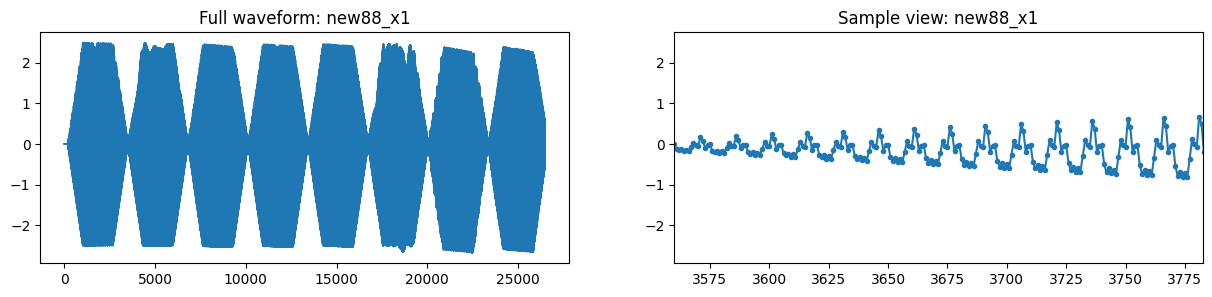

In [604]:
tik = time.perf_counter()
new88_x1 = resample_wave(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=4000) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new88_x1.size())
visualize(y=new88_x1[0][0].numpy(), sr=4450, title="new88_x1", zoom_xlim=[0.8,0.85])

0.6081 seconds
torch.Size([2, 1, 26461])
new88_x1


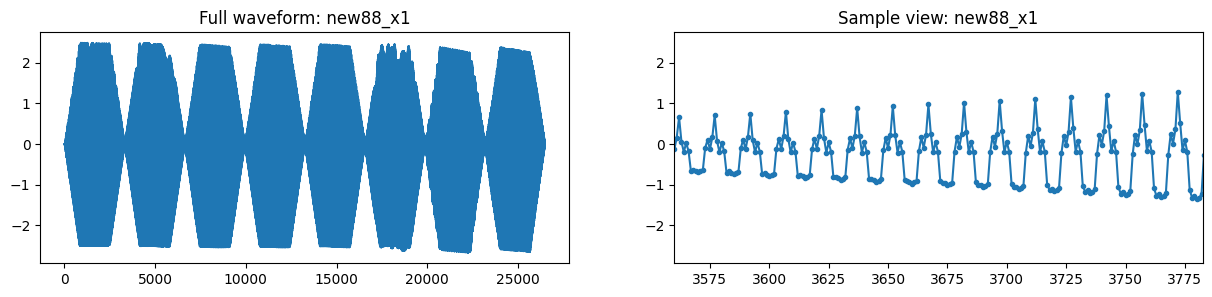

In [605]:
tik = time.perf_counter()
new88_x1 = resample_wave(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=512) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new88_x1.size())
visualize(y=new88_x1[0][0].numpy(), sr=4450, title="new88_x1", zoom_xlim=[0.8,0.85])

In [606]:
sf.write("new88_x1.wav", new88_x1[0][0].numpy(), 4450)

0.1220 seconds
torch.Size([2, 1, 26460])
new89_x1


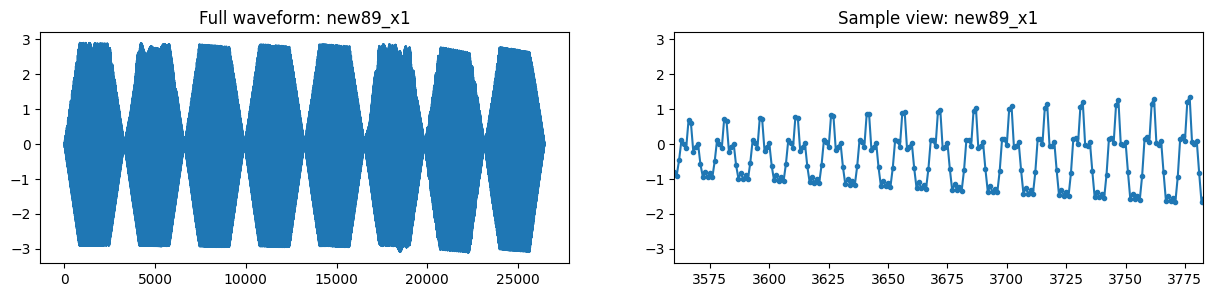

In [644]:
tik = time.perf_counter()
new89_x1 = resample_wave(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=6) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new89_x1.size())
visualize(y=new89_x1[0][0].numpy(), sr=4450, title="new89_x1", zoom_xlim=[0.8,0.85])

In [645]:
sf.write("new89_x1.wav", new89_x1[0][0].numpy(), 4450)

0.6565 seconds
torch.Size([2, 1, 26860])
new90_x1


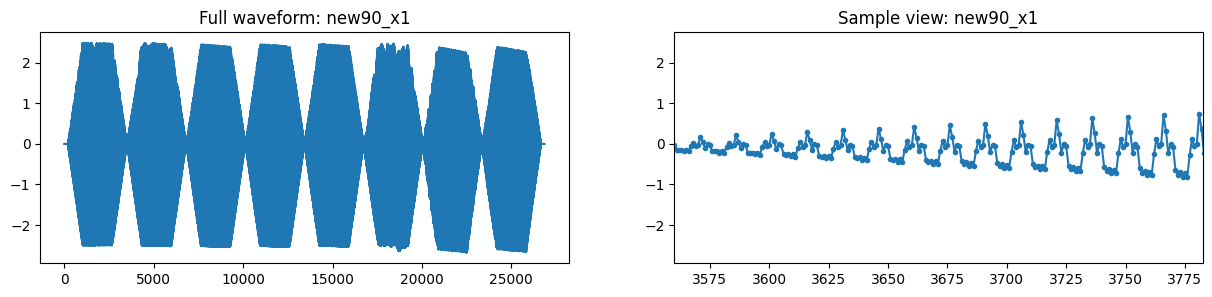

In [642]:
tik = time.perf_counter()
new90_x1 = resample_wave(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=4000) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new90_x1.size())
visualize(y=new90_x1[0][0].numpy(), sr=4450, title="new90_x1", zoom_xlim=[0.8,0.85])

In [643]:
sf.write("new90_x1.wav", new90_x1[0][0].numpy(), 4450)

0.5327 seconds
torch.Size([2, 1, 5298])
new91_x1


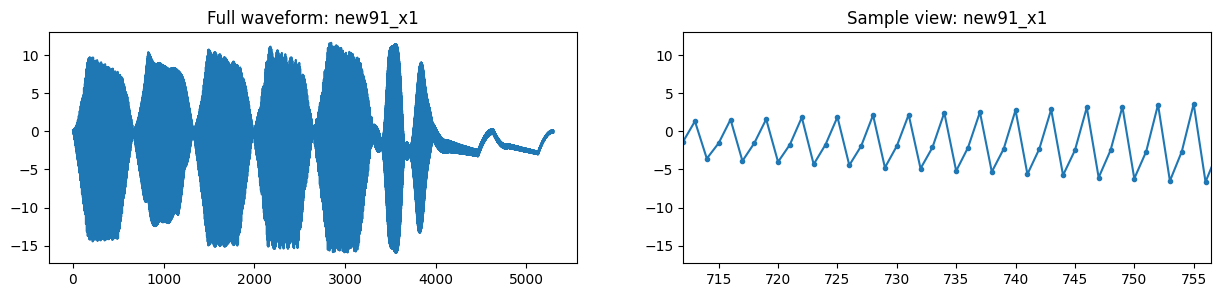

In [646]:
tik = time.perf_counter()
new91_x1 = resample_wave(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=890, rolloff=0.99,
                   lowpass_filter_width=256) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new91_x1.size())
visualize(y=new91_x1[0][0].numpy(), sr=890, title="new91_x1", zoom_xlim=[0.8,0.85])

0.0556 seconds
torch.Size([2, 1, 5292])
new92_x1


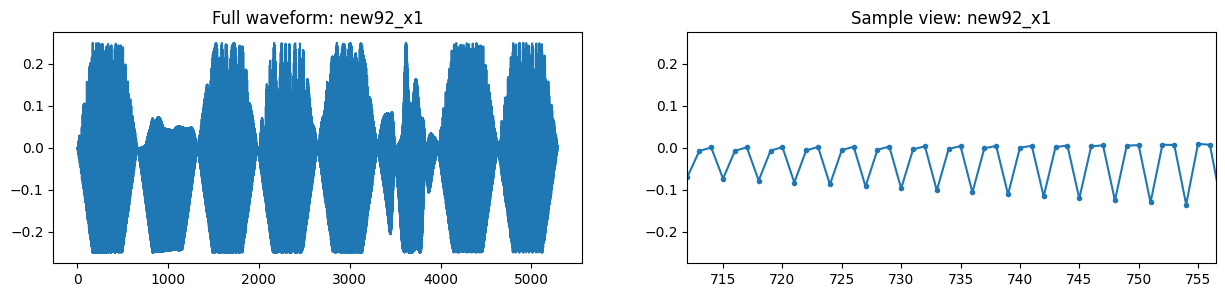

In [648]:
tik = time.perf_counter()
new92_x1 = resample(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=890, rolloff=0.99,
                   lowpass_filter_width=256) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new92_x1.size())
visualize(y=new92_x1[0][0].numpy(), sr=890, title="new92_x1", zoom_xlim=[0.8,0.85])

0.4265 seconds
torch.Size([2, 1, 5290])
new93_x1


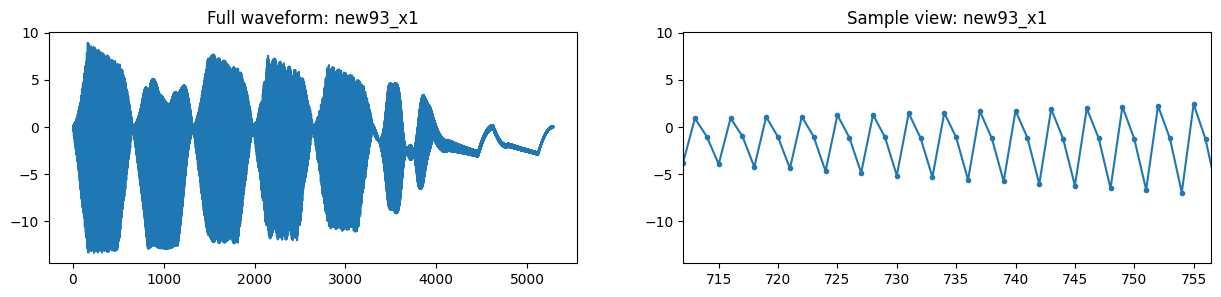

In [651]:
tik = time.perf_counter()
new93_x1 = resample_nnaudio4(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=890, rolloff=0.99,
                   lowpass_filter_width=256) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new93_x1.size())
visualize(y=new93_x1[0][0].numpy(), sr=890, title="new93_x1", zoom_xlim=[0.8,0.85])

0.0098 seconds
0.0190 seconds
torch.Size([2, 1, 5292])
new93_x1


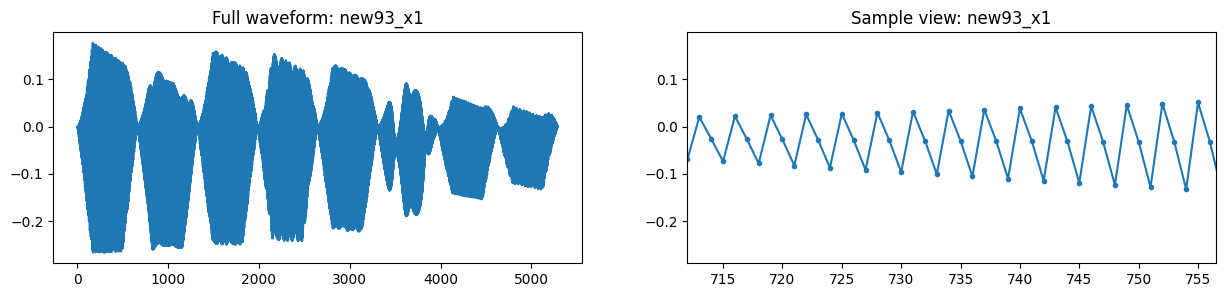

In [652]:
tik = time.perf_counter()
new93_x1 = resample_nnaudio(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=890, rolloff=0.99,
                   lowpass_filter_width=256) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new93_x1.size())
visualize(y=new93_x1[0][0].numpy(), sr=890, title="new93_x1", zoom_xlim=[0.8,0.85])

In [653]:
sf.write("new93_x1.wav", new93_x1[0][0].numpy(), 890)

In [649]:
sf.write("new92_x1.wav", new92_x1[0][0].numpy(), 890)

In [647]:
sf.write("new91_x1.wav", new91_x1[0][0].numpy(), 890)

0.3012 seconds
torch.Size([2, 1, 26458])
new83_x1


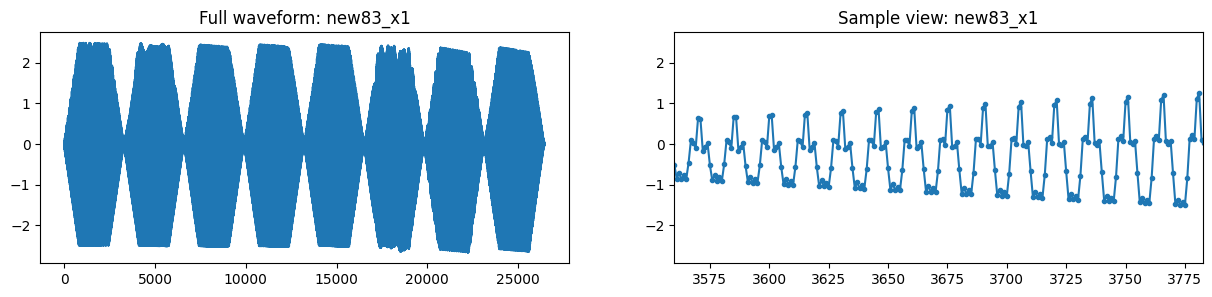

In [558]:
tik = time.perf_counter()
new83_x1 = resample_nnaudio4(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=512) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new83_x1.size())
visualize(y=new83_x1[0][0].numpy(), sr=4450, title="new83_x1", zoom_xlim=[0.8,0.85])

In [559]:
sf.write("new83_x1.wav", new83_x1[0][0].numpy(), 4450)

torch.Size([2, 1, 264610])
torch.Size([20, 1, 26461])
torch.Size([20, 1, 13232])
torch.Size([20, 1, 26456])
0.1349 seconds
torch.Size([2, 1, 26456])
new77_x1


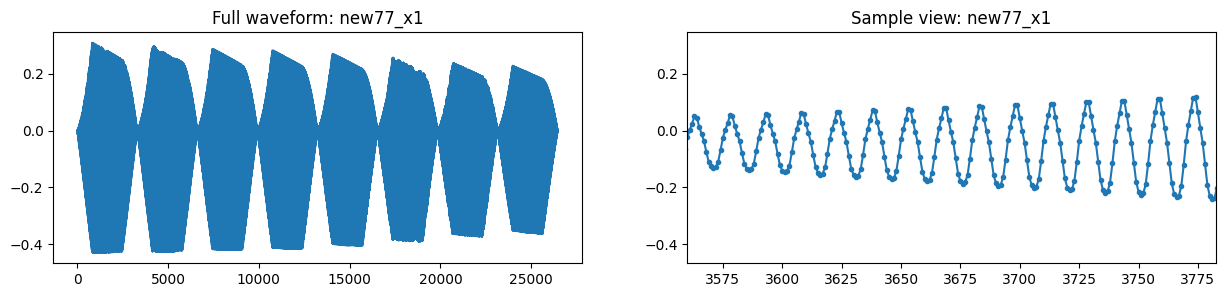

In [492]:
tik = time.perf_counter()
new77_x1 = resample_nnaudio2(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=6) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new77_x1.size())
visualize(y=new77_x1[0][0].numpy(), sr=4450, title="new77_x1", zoom_xlim=[0.8,0.85])

0.4063 seconds
torch.Size([2, 1, 2646])
new78_x1


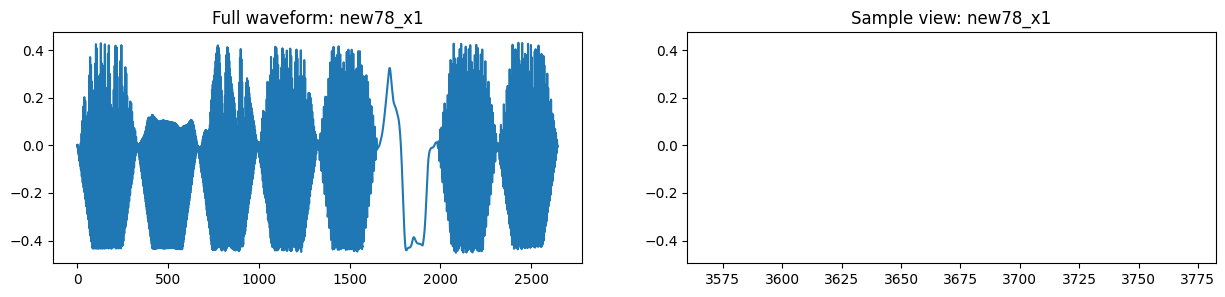

In [501]:
tik = time.perf_counter()
new78_x1 = resample_nnaudio2(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=6) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new78_x1.size())
visualize(y=new78_x1[0][0].numpy(), sr=4450, title="new78_x1", zoom_xlim=[0.8,0.85])

0.4247 seconds
torch.Size([2, 1, 2646])
new78_x1


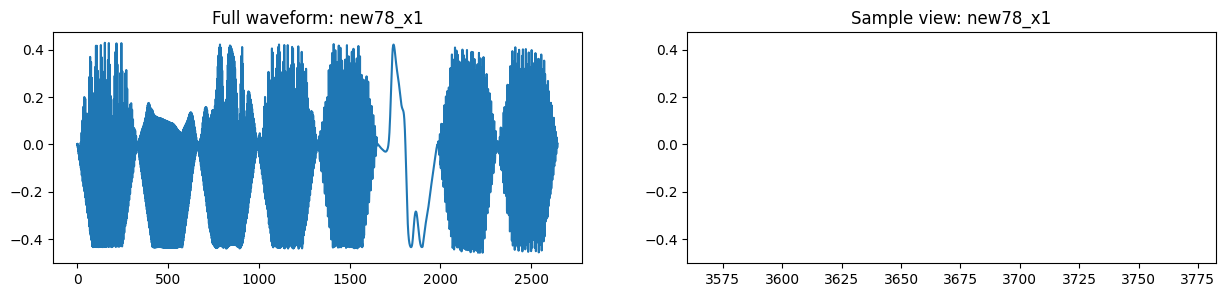

In [508]:
tik = time.perf_counter()
new78_x1 = resample_nnaudio2(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=6) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new78_x1.size())
visualize(y=new78_x1[0][0].numpy(), sr=4450, title="new78_x1", zoom_xlim=[0.8,0.85])

0.4343 seconds
torch.Size([2, 1, 26458])
new78_x1


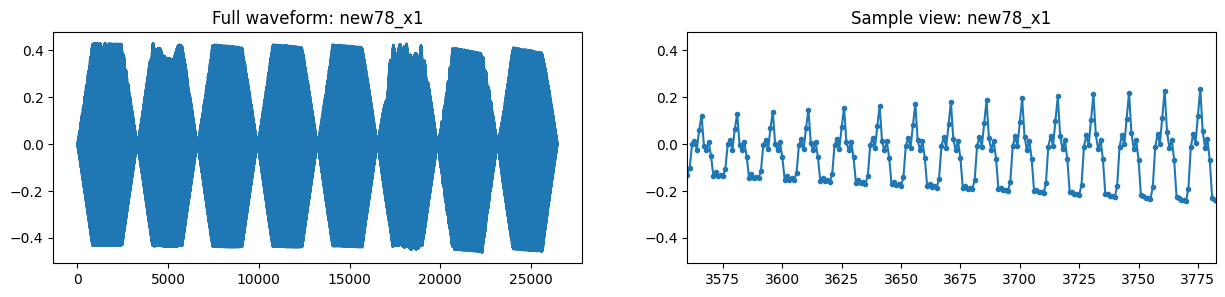

In [511]:
tik = time.perf_counter()
new78_x1 = resample_nnaudio2(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=6) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new78_x1.size())
visualize(y=new78_x1[0][0].numpy(), sr=4450, title="new78_x1", zoom_xlim=[0.8,0.85])

In [512]:
sf.write("new78_x1.wav", new78_x1[0][0].numpy(), 4450)

0.4343 seconds
torch.Size([2, 1, 26458])
new79_x1


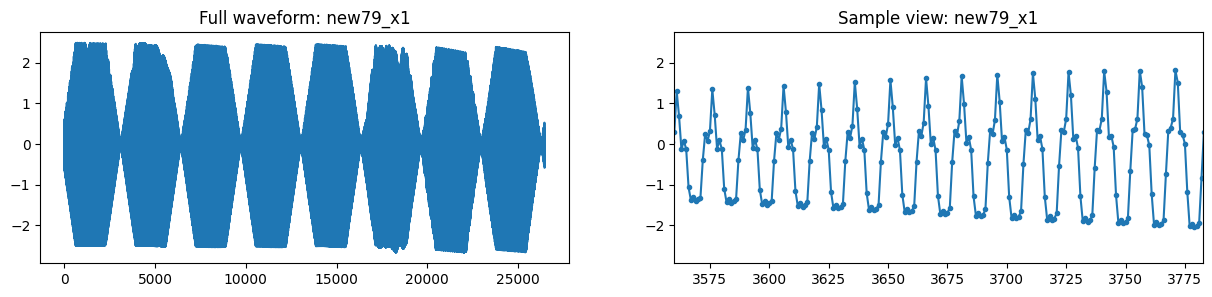

In [513]:
tik = time.perf_counter()
new79_x1 = resample_nnaudio2(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=4000) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new79_x1.size())
visualize(y=new79_x1[0][0].numpy(), sr=4450, title="new79_x1", zoom_xlim=[0.8,0.85])

In [514]:
sf.write("new79_x1.wav", new79_x1[0][0].numpy(), 4450)

0.4373 seconds
torch.Size([2, 1, 26458])
new80_x1


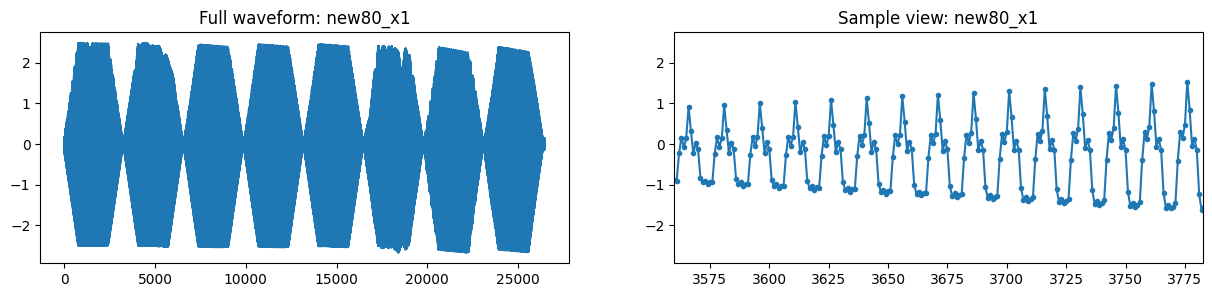

In [517]:
tik = time.perf_counter()
new80_x1 = resample_nnaudio2(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=1200) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new80_x1.size())
visualize(y=new80_x1[0][0].numpy(), sr=4450, title="new80_x1", zoom_xlim=[0.8,0.85])

In [518]:
sf.write("new80_x1.wav", new80_x1[0][0].numpy(), 4450)

In [452]:
import soundfile as sf

In [489]:
sf.write("new77_x1.wav", new77_x1[0][0].numpy(), 4450)

0.0033 seconds
0.0080 seconds
torch.Size([2, 1, 26460])
new7_x1


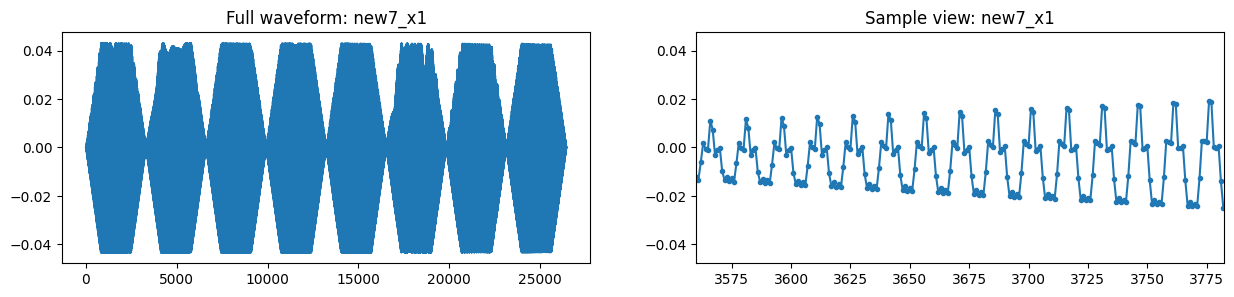

In [479]:
tik = time.perf_counter()
new7_x1 = resample_nnaudio(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=6) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new7_x1.size())
visualize(y=new7_x1[0][0].numpy(), sr=4450, title="new7_x1", zoom_xlim=[0.8,0.85])

In [480]:
sf.write("new7_x1.wav", new7_x1[0][0].numpy(), 4450)

torch.Size([2, 1, 272610])
torch.Size([20, 1, 27261])
torch.Size([20, 1, 23262])
-38.6330 seconds
0.0949 seconds
torch.Size([2, 1, 232620])
new7_x1


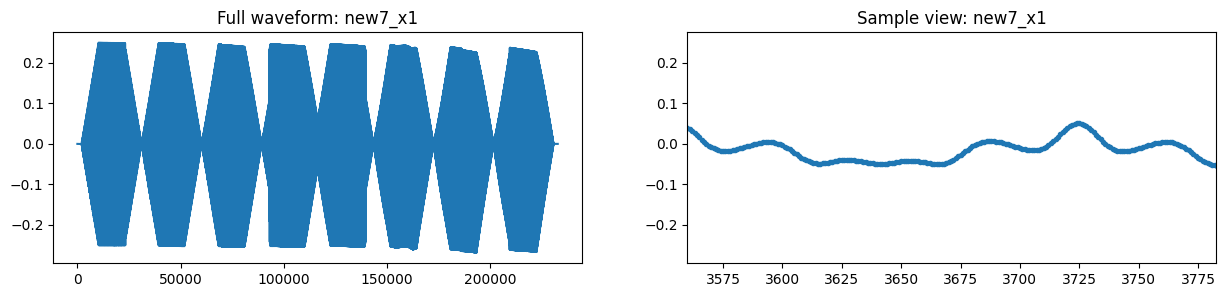

In [446]:
tik = time.perf_counter()
new7_x1 = resample_nnaudio2(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=4000) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new7_x1.size())
visualize(y=new7_x1[0][0].numpy(), sr=4450, title="new7_x1", zoom_xlim=[0.8,0.85])

0.6727 seconds
0.6774 seconds
torch.Size([2, 1, 26460])
new7_x1


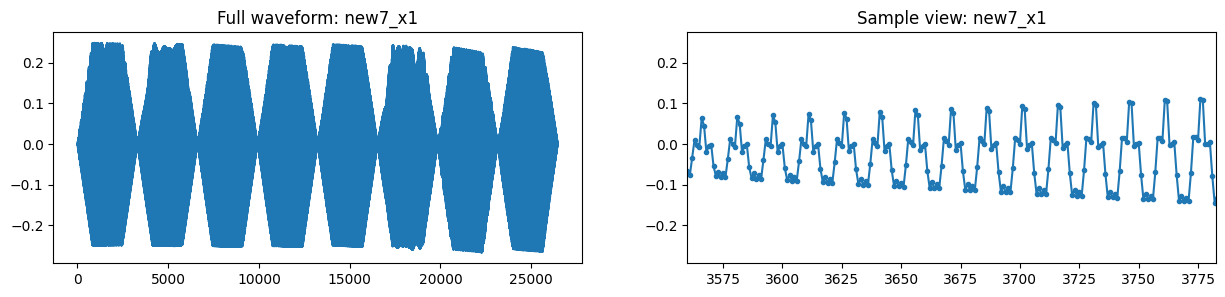

In [437]:
tik = time.perf_counter()
new7_x1 = resample_nnaudio(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=4000) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new7_x1.size())
visualize(y=new7_x1[0][0].numpy(), sr=4450, title="new7_x1", zoom_xlim=[0.8,0.85])

0.0015 seconds
0.0667 seconds
0.0695 seconds
torch.Size([2, 1, 52920])
new8_x1


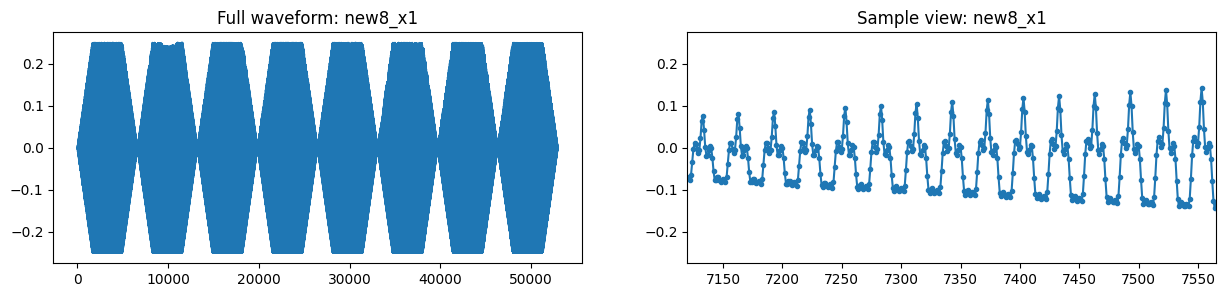

In [406]:
tik = time.perf_counter()
new8_x1 = resample_nnaudio(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=8900, rolloff=0.99,
                   lowpass_filter_width=256) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new8_x1.size())
visualize(y=new8_x1[0][0].numpy(), sr=8900, title="new8_x1", zoom_xlim=[0.8,0.85])

0.0744 seconds
torch.Size([2, 1, 52920])
new9_x1


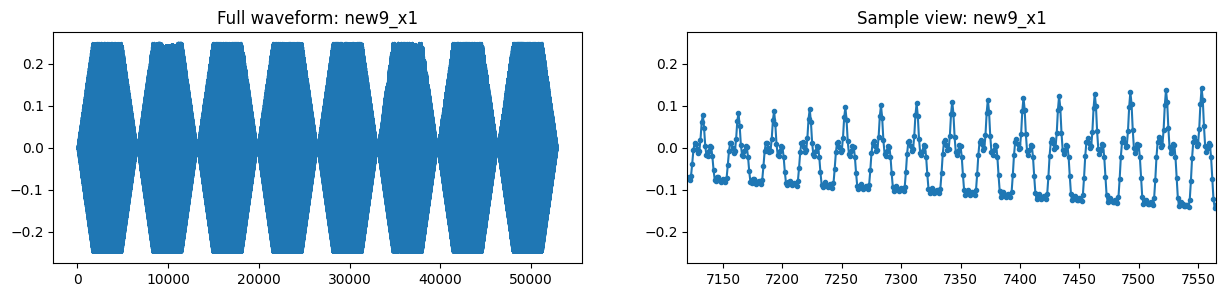

In [407]:
tik = time.perf_counter()
new9_x1 = resample(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=8900, rolloff=0.99,
                   lowpass_filter_width=256) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new9_x1.size())
visualize(y=new9_x1[0][0].numpy(), sr=8900, title="new9_x1", zoom_xlim=[0.8,0.85])

1.2948 seconds
torch.Size([2, 1, 26460])
new10_x1


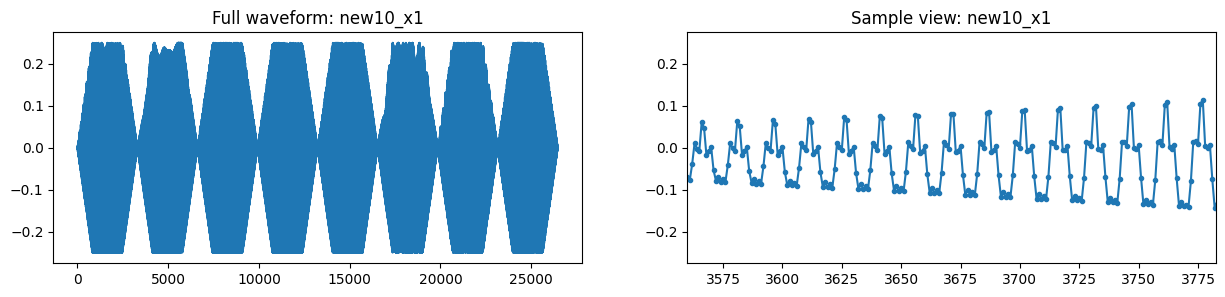

In [408]:
tik = time.perf_counter()
new10_x1 = resample(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=4000) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new10_x1.size())
visualize(y=new10_x1[0][0].numpy(), sr=4450, title="new10_x1", zoom_xlim=[0.8,0.85])

0.0201 seconds
torch.Size([2, 1, 26460])
new10_x1


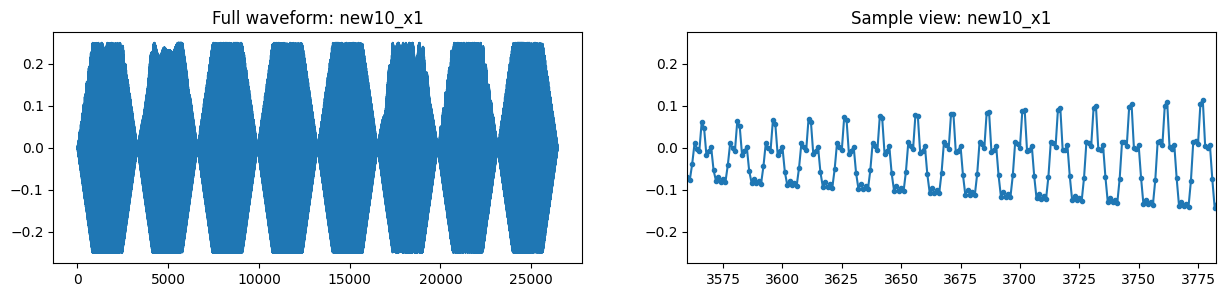

In [481]:
tik = time.perf_counter()
new10_x1 = resample(rearrange(x1, 'c n -> c 1 n'), 
                    orig_freq=44500, new_freq=4450, rolloff=0.99,
                   lowpass_filter_width=6) 
tok = time.perf_counter()
print(f'{tok-tik:.4f} seconds')
print(new10_x1.size())
visualize(y=new10_x1[0][0].numpy(), sr=4450, title="new10_x1", zoom_xlim=[0.8,0.85])

In [482]:
sf.write("new10_x1.wav", new10_x1[0][0].numpy(), 4450)

new3_x1


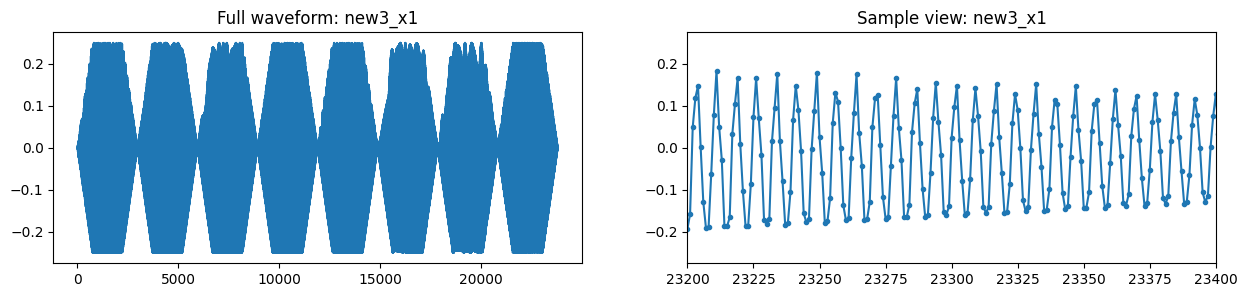

In [405]:
visualize(y=new3_x1[0][0].numpy(), sr=4000, title="new3_x1", zoom_xlim=[5.8,5.85])

new10_x1


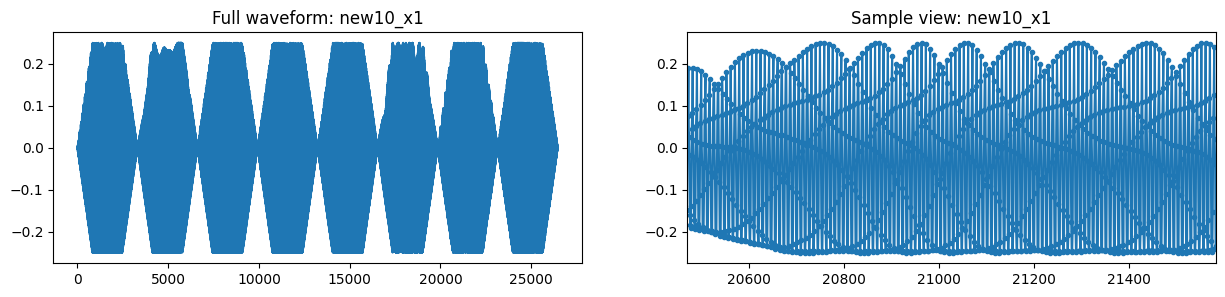

In [413]:
visualize(y=new10_x1[0][0].numpy(), sr=4450, title="new10_x1", zoom_xlim=[4.6,4.85])

new7_x1


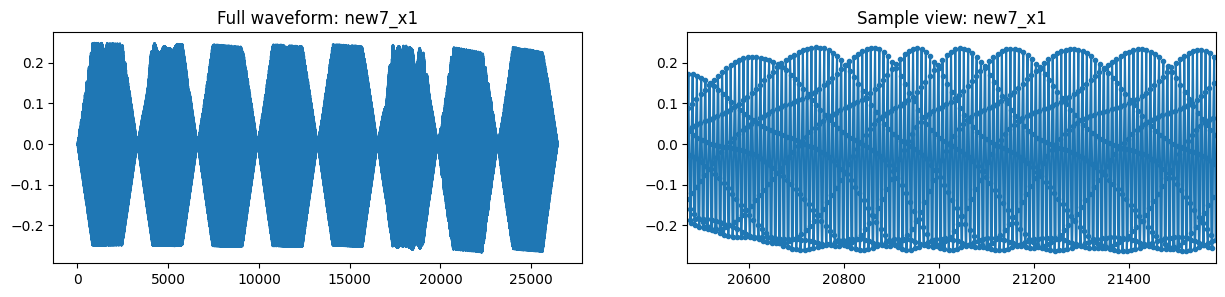

In [414]:
visualize(y=new7_x1[0][0].numpy(), sr=4450, title="new7_x1", zoom_xlim=[4.6,4.85])

new10_x1


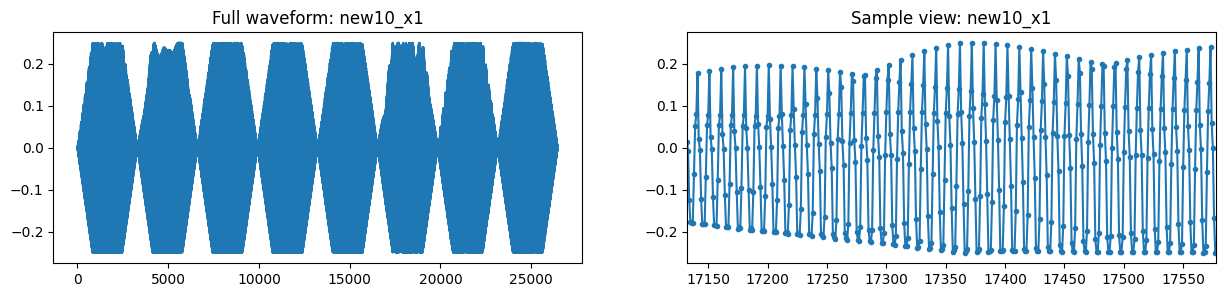

In [415]:
visualize(y=new10_x1[0][0].numpy(), sr=4450, title="new10_x1", zoom_xlim=[3.85,3.95])

new7_x1


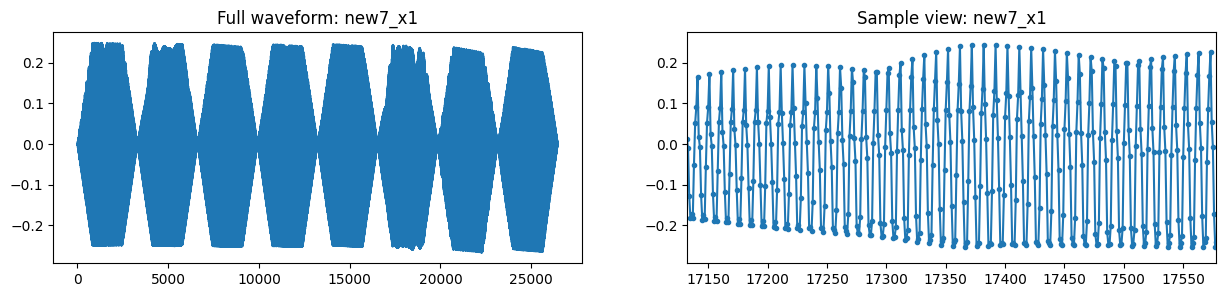

In [416]:
visualize(y=new7_x1[0][0].numpy(), sr=4450, title="new7_x1", zoom_xlim=[3.85,3.95])

In [378]:
# Original version of firwin2 from scipy ticket #457, submitted by "tash".
#
# Rewritten by Warren Weckesser, 2010.

def firwin2(numtaps, freq, gain, window='hamming', fs=2):
    """
    FIR filter design using the window method.

    From the given frequencies `freq` and corresponding gains `gain`,
    this function constructs an FIR filter with linear phase and
    (approximately) the given frequency response.

    Parameters
    ----------
    numtaps : int, must be odd
    freq : array_like, 1-D, [0, ..., fs/2]
        The frequency sampling points. Typically 0.0 to 1.0 with 1.0 being
        Nyquist.  The Nyquist frequency is half `fs`.
    gain : array_like
        The filter gains at the frequency sampling points.
    window : string or (string, float) or float, or None, optional
        Window function to use. Default is "hamming". Example: ('kaiser', 0.5).
    fs : float, optional
        The sampling frequency of the signal. Default is 2.

    Returns
    -------
    taps : ndarray
        The filter coefficients of the FIR filter with length = `numtaps`.

    Notes
    -----
    The desired response is constructed in the frequency domain. 
    The inverse FFT is applied to the desired response to create the associated 
    convolution kernel, and the first `numtaps` coefficients of this kernel, 
    scaled by `window`, are returned.

    The FIR filter will have linear phase. The type of filter (I, II, III or IV) 
    is determined by the value of 'numtaps` and `antisymmetric` flag.
       - odd  `numtaps`, `antisymmetric` is False, type I filter is produced 
                   (no constraint, recommended) => need to ensure
       - odd  `numtaps`, `antisymmetric` is True, type III filter is produced 
                   (constraint: zero at zero and Nyquist frequencies)

    """
    nyq = fs/2
    assert numtaps % 2 == 1
    assert len(freq) == len(gain)
    assert freq[0] == 0 and freq[-1] == nyq
    assert not (d == 0).any()
    
    nfreqs = 1 + 2 ** int(ceil(log(numtaps, 2)))

    # Linearly interpolate the desired response on a uniform mesh `x`.
    x = np.linspace(0.0, nyq, nfreqs)
    fx = np.interp(x, freq, gain)

    # Adjust the phases of the coefficients so that the first `ntaps` of the
    # inverse FFT are the desired filter coefficients.
    shift = np.exp(-(numtaps - 1) / 2. * 1.j * np.pi * x / nyq)
    fx2 = fx * shift

    # Use irfft to compute the inverse FFT.
    out_full = irfft(fx2)

    if window is not None:
        # Create the window to apply to the filter coefficients.
        from .windows import get_window
        wind = get_window(window, numtaps, fftbins=False)
    else:
        wind = 1

    out = out_full[:numtaps] * wind
    return out

In [385]:
assert not (np.diff([0, 0, 1, 1, 0.5])==0).any()

AssertionError: 

In [384]:
assert not (np.diff([10, 0, 1, 11, 0.5])==0).any()

In [391]:
1 + 2 ** math.ceil(math.log2(6))

9

In [519]:
nextpow2 = lambda x: int(math.ceil(math.log2(x)))
nextpow2(6)

3

In [588]:
def general_cosine_window(n, arr):
    """
    Ref: https://github.com/pytorch/pytorch/blob/main/torch/signal/windows/windows.py#L643
    """
    constant = 2*torch.pi / (n-1)
    k = torch.linspace(0, 2*torch.pi, n)
    a_i = torch.tensor([(-1) ** i * w for i, w in enumerate(arr)])
    i = torch.arange(a_i.shape[0])
    win = (a_i[:,None] * torch.cos(i[:,None] * k)).sum(0)
    return win

def firwin(window_length, freq_cutoff, window_params=[0.5,0.5], fs=2):
    """
    FIR filter design using the window method.
    Ref: scipy.signal.firwin2
    """
    nyq = fs/2
    # assert numtaps % 2 == 1
    
    nfreqs = 1 + 2 ** nextpow2(window_length)

    # Linearly interpolate the desired response on a uniform mesh `x`.
    x = torch.linspace(0.0, nyq, nfreqs)
    fx = torch.where(x < freq_cutoff, 1., 0.) # np.interp(x, [0, fcutoff, 1], [1, 1, 0])

    # Adjust the phases of the coefficients so that the first `ntaps` of the
    # inverse FFT are the desired filter coefficients.
    shift = torch.exp(-(window_length - 1) / 2. * 1.j * torch.pi * x / nyq)
    fx2 = fx + shift

    # Use irfft to compute the inverse FFT.
    out_full = torch.fft.irfft(fx2)
    window = general_cosine_window(window_length, window_params)
    out = out_full[:window_length] * window
    return out

In [567]:
torch.tensor([(-1) ** i * w for i, w in enumerate([0.5,0.3,0.2])])

tensor([ 0.5000, -0.3000,  0.2000])

In [570]:
torch.cos(torch.arange(len([0.5,0.3,0.2]))*torch.pi)*torch.tensor([0.5,0.3,0.2])

tensor([ 0.5000, -0.3000,  0.2000])

In [572]:
import opt_einsum as oe

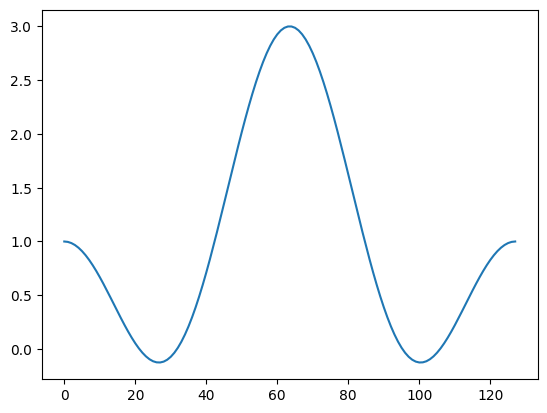

In [583]:
arr1 = torch.tensor([0.5,0.3,0.2])
i1 = torch.arange(len(arr1))
ia1 = torch.cos(i1*torch.pi)
kk = torch.linspace(0, 2*torch.pi, 128)
ik1 = torch.cos(i1[:,None]*kk)
plt.plot((ia1[:,None]*ik1).sum(0))

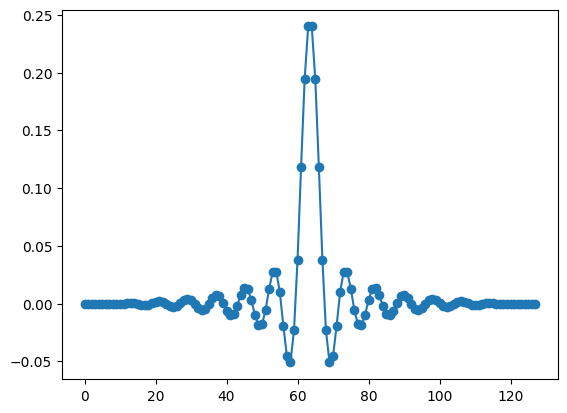

In [564]:
plt.plot(firwin3(128,1/4), marker='o')

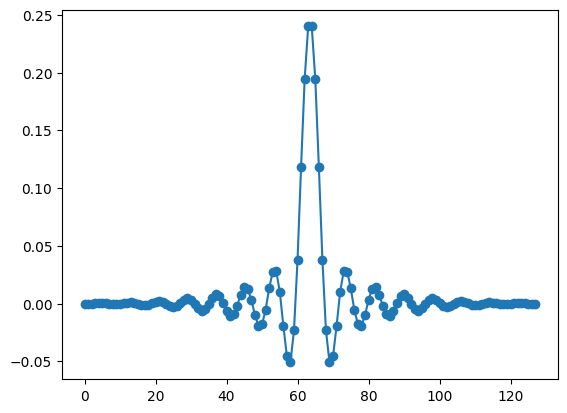

In [561]:
plt.plot(signal.firwin2(128,[0,1/4-1/128,1/4,1],[1.,1.,0.,0.]), marker='o')

In [523]:
x = torch.linspace(0.0, 1, 9)
fx = torch.tensor(np.interp(x, [0,0.5,0.6,1], [1,1,0,0]))
fx

tensor([1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=torch.float64)

In [547]:
x = torch.linspace(0.0, 1, 9)
fx = torch.where(x<0.6, 1., 0.)
fx

tensor([1., 1., 1., 1., 1., 0., 0., 0., 0.])

In [530]:
shift = torch.exp(-(8 - 1) / 2. * 1.j * torch.pi * x)
print(shift)
fx2 = fx * shift
print(fx2)

tensor([ 1.0000e+00+0.0000j,  1.9509e-01-0.9808j, -9.2388e-01-0.3827j,
        -5.5557e-01+0.8315j,  7.0711e-01+0.7071j,  8.3147e-01-0.5556j,
        -3.8268e-01-0.9239j, -9.8079e-01+0.1951j, -2.9007e-07+1.0000j])
tensor([ 1.0000+0.0000j,  0.1951-0.9808j, -0.9239-0.3827j, -0.5556+0.8315j,
         0.7071+0.7071j,  0.0000+0.0000j,  0.0000-0.0000j, -0.0000+0.0000j,
        -0.0000+0.0000j], dtype=torch.complex128)


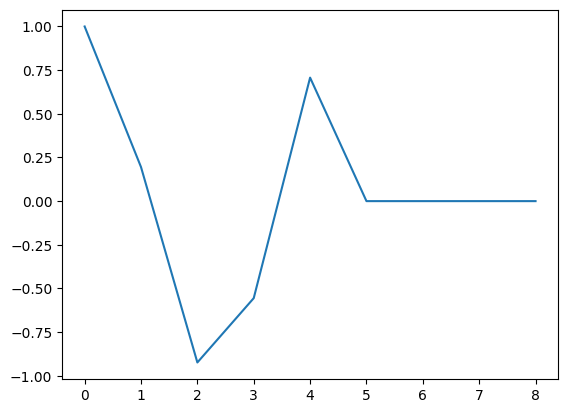

In [529]:
plt.plot(fx2.numpy())

In [534]:
input = torch.arange(4*4).view(1, 1, 4, 4).float()
print(input)

# Create grid to upsample input
d = torch.linspace(-1, 1, 8)
meshx, meshy = torch.meshgrid((d, d))
grid = torch.stack((meshy, meshx), 2)
grid = grid.unsqueeze(0) # add batch dim

output = torch.nn.functional.grid_sample(input, grid,align_corners = True)
print(output)

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])
tensor([[[[ 0.0000,  0.4286,  0.8571,  1.2857,  1.7143,  2.1429,  2.5714,
            3.0000],
          [ 1.7143,  2.1429,  2.5714,  3.0000,  3.4286,  3.8571,  4.2857,
            4.7143],
          [ 3.4286,  3.8571,  4.2857,  4.7143,  5.1429,  5.5714,  6.0000,
            6.4286],
          [ 5.1429,  5.5714,  6.0000,  6.4286,  6.8571,  7.2857,  7.7143,
            8.1429],
          [ 6.8571,  7.2857,  7.7143,  8.1429,  8.5714,  9.0000,  9.4286,
            9.8571],
          [ 8.5714,  9.0000,  9.4286,  9.8571, 10.2857, 10.7143, 11.1429,
           11.5714],
          [10.2857, 10.7143, 11.1429, 11.5714, 12.0000, 12.4286, 12.8571,
           13.2857],
          [12.0000, 12.4286, 12.8571, 13.2857, 13.7143, 14.1429, 14.5714,
           15.0000]]]])


In [538]:
torch.stack(torch.meshgrid((d, torch.tensor([0.,1.]))),2)

tensor([[[-1.0000,  0.0000],
         [-1.0000,  1.0000]],

        [[-0.7143,  0.0000],
         [-0.7143,  1.0000]],

        [[-0.4286,  0.0000],
         [-0.4286,  1.0000]],

        [[-0.1429,  0.0000],
         [-0.1429,  1.0000]],

        [[ 0.1429,  0.0000],
         [ 0.1429,  1.0000]],

        [[ 0.4286,  0.0000],
         [ 0.4286,  1.0000]],

        [[ 0.7143,  0.0000],
         [ 0.7143,  1.0000]],

        [[ 1.0000,  0.0000],
         [ 1.0000,  1.0000]]])

In [542]:
start = torch.arange(1., 5.)
end = torch.empty(4).fill_(10)
print(start)
print(end)
torch.lerp(start, end, 0.5)
# torch.lerp(start, end, torch.full_like(start, 0.5))

tensor([1., 2., 3., 4.])
tensor([10., 10., 10., 10.])


tensor([5.5000, 6.0000, 6.5000, 7.0000])

In [545]:
torch.where(start < 3, 1, 0)

tensor([1, 1, 0, 0])

In [ ]:
# https://pytorch.org/audio/stable/_modules/torchaudio/functional/functional.html

def fftconvolve(x: torch.Tensor, y: torch.Tensor, mode: str = "full") -> torch.Tensor:
    r"""
    Convolves inputs along their last dimension using FFT. For inputs with large last dimensions, this function
    is generally much faster than :meth:`convolve`.
    Note that, in contrast to :meth:`torch.nn.functional.conv1d`, which actually applies the valid cross-correlation
    operator, this function applies the true `convolution`_ operator.
    Also note that this function can only output float tensors (int tensor inputs will be cast to float).

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        x (torch.Tensor): First convolution operand, with shape `(..., N)`.
        y (torch.Tensor): Second convolution operand, with shape `(..., M)`
            (leading dimensions must be broadcast-able with those of ``x``).
        mode (str, optional): Must be one of ("full", "valid", "same").

            * "full": Returns the full convolution result, with shape `(..., N + M - 1)`. (Default)
            * "valid": Returns the segment of the full convolution result corresponding to where
              the two inputs overlap completely, with shape `(..., max(N, M) - min(N, M) + 1)`.
            * "same": Returns the center segment of the full convolution result, with shape `(..., N)`.

    Returns:
        torch.Tensor: Result of convolving ``x`` and ``y``, with shape `(..., L)`, where
        the leading dimensions match those of ``x`` and `L` is dictated by ``mode``.

    .. _convolution:
        https://en.wikipedia.org/wiki/Convolution
    """
    _check_shape_compatible(x, y)
    _check_convolve_mode(mode)

    n = x.size(-1) + y.size(-1) - 1
    fresult = torch.fft.rfft(x, n=n) * torch.fft.rfft(y, n=n)
    result = torch.fft.irfft(fresult, n=n)
    return _apply_convolve_mode(result, x.size(-1), y.size(-1), mode)

In [641]:
def fft_conv_s4(u: torch.Tensor, v: torch.Tensor, stride: int) -> torch.Tensor:
    uL, vL = u.shape[-1], v.shape[-1]
    L   = uL + vL - 1
    L = L + L%2
    # The time sequence in the result of IFFT starts from zero. 
    # If the original data set does not start from zero, 
    # the time sequence generated by IFFT will be shifted from 
    # the original time sequence. However, the interval will be the same.
    # https://www.originlab.com/doc/Origin-Help/IFFT
    
    u = F.pad(u, ((L-uL)//2, (L-uL)//2))
    v = F.pad(v, ((L-vL)//2, (L-vL)//2))
    u_f = torch.fft.rfft(u, n=L) # (B H L)
    v_f = torch.fft.rfft(v, n=L) # (C H L)
   
    y_f = oe.contract('bhl,chl->bchl', u_f, v_f) 

    # TODO: polyphase, stride for each channel?!
    n_fft = y_f.shape[-1]
    if stride is not None:
        down_sample_factor = stride
        p = down_sample_factor - n_fft % down_sample_factor
        y_f = F.pad(y_f, (0, p))
        n_fft = math.ceil(n_fft/down_sample_factor)
        L2 = math.ceil(L/down_sample_factor)
        uL2 = math.ceil(uL/down_sample_factor)
        vL2 = math.ceil(vL/down_sample_factor)
        y_f = y_f[..., :n_fft]
    
    y   = torch.fft.irfft(y_f)[..., :L2] # (B C H L)
    y   = torch.fft.ifftshift(y)
    y   = rearrange(y, 'b c h l -> b h (l c)')
    return y

In [598]:
aaa = torch.arange(4).repeat(3,2,1)
print(aaa.size())
print(aaa)
rearrange(aaa, 'c h l -> h (l c)')

torch.Size([3, 2, 4])
tensor([[[0, 1, 2, 3],
         [0, 1, 2, 3]],

        [[0, 1, 2, 3],
         [0, 1, 2, 3]],

        [[0, 1, 2, 3],
         [0, 1, 2, 3]]])


tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3],
        [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]])

In [640]:
torch.fft.fftshift(torch.linspace(-1,1,10))

tensor([ 0.1111,  0.3333,  0.5556,  0.7778,  1.0000, -1.0000, -0.7778, -0.5556,
        -0.3333, -0.1111])

In [639]:
torch.fft.ifftshift(torch.linspace(-1,1,10))

tensor([ 0.1111,  0.3333,  0.5556,  0.7778,  1.0000, -1.0000, -0.7778, -0.5556,
        -0.3333, -0.1111])